Lane Following Problem
===========================

The dynamics model of an omnidirectional vehicle with no friction is defined by the following equation:

$$
\dot{p}^x(t) = (v_k + \dot{v}_k(t-T_s k))cos(\theta_k + \theta_k(t - T_sk))
$$
$$
\dot{p}^y(t) = (v_k + \dot{v}_k(t - T_s k))sin(\theta_k + \theta_k(t - T_s k))
$$

iLQR is applied to a vehicle in order to control them to follow a reference trajectory at a terminal velocity of $10 m/s$.

The state vector $\textbf{x}$ is defined as follows:
$$\begin{equation*}
\textbf{x} = \begin{bmatrix}
    p^x & p^y & v & \theta
    \end{bmatrix}^T
\end{equation*}$$

The action vector $\textbf{u}$ is defined as follows:
$$\begin{equation*}
\textbf{u} = \begin{bmatrix}
   \dot{v} & \delta
    \end{bmatrix}^T
\end{equation*}$$

**Note**: That since this dynamics model is nonlinear, this problem can be solved
more efficiently with a simple Linear Quadratic Regulator (LQR) instead. This
example is just used to demonstrate how to setup an auto-differentiated
dynamics model.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function
import sys
import os
sys.path.append(os.path.abspath('../'))
import random
import ilqr
import math

In [3]:
import numpy as np
import theano.tensor as T
import matplotlib.pyplot as plt


In [4]:
from ilqr import iLQR
from ilqr.cost import PathQRCost
from ilqr.examples.car import CarDynamics, CarCost

from bc import *
import pickle

In [5]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged):
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    final_state = xs[-1]
    final_control = us[-1]
    if iteration_count % 60 == 0:
        print("iteration", iteration_count, info, J_opt, final_state, final_control)


In [6]:
dt = 0.05
wheel_diameter = 1.0
dynamics = CarDynamics(dt, l=wheel_diameter)

An instantaneous cost function $l(\textbf{x}_t, \textbf{u}_t)$ is defined as follows:

$$
l(\textbf{x}_t, \textbf{u}_t) = \textbf{x}_t^T Q \textbf{x}_t + \textbf{u}_t^T R \textbf{u}_t
$$

where $Q$ is the state error and $R$ is the control error.

In order to approach the two vehicles to each other, $Q$ is set up to penalize differences in positions as $||\textbf{x}_0 - \textbf{x}_1||^2$ while penalizing non-zero velocities.

The following code generates the lane and boundaries. There are 150 way points along the reference trajectory. The boundary is +-3 vertically away from the reference trajecotry.S

In [7]:

def lane(posx):
    ts = [90, 100, 150]
    rate = 8.0
    height = 10.0
    if posx <= ts[0]:
        return -height * np.exp((posx - ts[0])/(1 * rate)), np.arctan(-height * np.exp((posx - ts[0])/(1 * rate)/(1 * rate)))
    elif posx > ts[0] and posx <= ts[1]:
        return -height * np.exp(ts[0] - ts[0])  + (posx - ts[0])/10.0, 1.0/10.0
    elif posx > ts[1]:
        return -height * np.exp((ts[1] - posx)/(1 * rate)) + (ts[1] - ts[0])/10.0, np.arctan(+ height * np.exp((ts[1] - posx)/(1 * rate)))

'''

def nominal(posx):
    ts = [80, 90, 150]
    rate = 6.0
    height = 6.0
    if posx <= ts[0]:
        return -height * np.exp((posx - ts[0])/(1 * rate)), np.arctan(-height * np.exp((posx - ts[0])/(1 * rate)/(1 * rate)))
    elif posx > ts[0] and posx <= ts[1]:
        return -height * np.exp(ts[0] - ts[0]), np.arctan(0)
    elif posx > ts[1]:
        return -height * np.exp((ts[1] - posx)/(1 * rate)), np.arctan(+ height * np.exp((ts[1] - posx)/(1 * rate)))


def lane(posx):
    ts = [30, 60, 90, 120]
    rate = 6.0
    height = 6.0
    if posx <= ts[0]:
        return -height * np.exp((posx - ts[0])/rate), np.arctan(-height * np.exp((posx - ts[0])/rate)/rate)
    elif posx > ts[0] and posx <= ts[1]:
        return -height * np.exp(ts[0] - ts[0]), np.arctan(0)
    elif posx > ts[1] and posx <= ts[3]:
        return -height * np.exp((ts[1] - posx)/(2 * rate)), np.arctan(+ height * np.exp((ts[1] - posx)/(2 * rate)))
    #elif posx > ts[2] and posx <= ts[3]:
    #    return -height * np.exp((posx - ts[2])/rate), np.arctan(-height * np.exp((posx - ts[2])/rate)/rate)
    elif posx > ts[3]:
        return -height * np.exp((posx - ts[3])/(2 * rate)), np.arctan(+ height * np.exp((ts[3] - posx)/(2 * rate)))
    
def nominal(posx):
    ts = [30, 60, 90, 120]
    rate = 6.0
    height = 6.0
    if posx <= ts[0]:
        return -height * np.exp((posx - ts[0])/rate), np.arctan(-height * np.exp((posx - ts[0])/rate)/rate)
    elif posx > ts[0] and posx <= ts[1]:
        return -height * np.exp(ts[0] - ts[0]), np.arctan(0)
    elif posx > ts[1] and posx <= ts[3]:
        return -height * np.exp((ts[1] - posx)/(2 * rate)), np.arctan(+ height * np.exp((ts[1] - posx)/(2 * rate)))
    #elif posx > ts[2] and posx <= ts[3]:
    #    return -height * np.exp((posx - ts[2])/rate), np.arctan(-height * np.exp((posx - ts[2])/rate)/rate)
    elif posx > ts[3]:
        return -height * np.exp((posx - ts[3])/(2 * rate)), np.arctan(+ height * np.exp((posx - ts[3])/(2 * rate)))
'''

def barrier_u(x):
    ts = [80, 90, 150]
    if x[0] <= ts[0]:
        return np.array([+ 1 + x[0], + 3 + lane(x[0])[0], x[2] + 1.0, x[3]])
    elif x[0] > ts[0] and x[0] <= ts[1]:
        return np.array([+ 1 + x[0], + 3 + lane(x[0])[0], x[2] + 1.0, x[3]])
    elif x[0] > ts[1]:
        return np.array([+ 1 + x[0], + 3 + lane(x[0])[0], x[2] + 1.0, x[3]])
                                                                      
def barrier_l(x):
    ts = [80, 90, 150]
    if x[0] <= ts[0]:
        return np.array([- 1 + x[0], -3 + lane(x[0])[0], x[2] + 1.0, x[3]])
    elif x[0] > ts[0] and x[0] <= ts[1]:
        return np.array([- 1 + x[0], -3 + lane(x[0])[0], x[2] + 1.0, x[3]])
    elif x[0] > ts[1]:
        return np.array([- 1 + x[0], -3 + lane(x[0])[0], x[2] + 1.0, x[3]])
    
def nominal(x):
    return barrier_u(x)* 0.5 + barrier_l(x) * 0.5

  

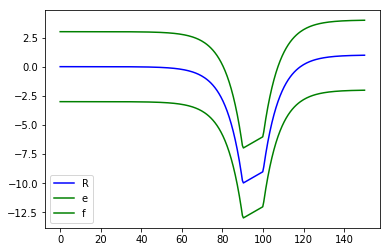

In [8]:
posx_path = np.linspace(0, 150, 300)

x_lane = [[posx_path[i], lane(posx_path[i])[0], 10, lane(posx_path[i])[1]] for i in range(300)]
x_nominal = [[nominal(x_lane[i])[0], nominal(x_lane[i])[1], nominal(x_lane[i])[2], nominal(x_lane[i])[3]] for i in range(300)]
x_barrier_u = [[barrier_u(x_lane[i])[0], barrier_u(x_lane[i])[1], barrier_u(x_lane[i])[2], barrier_u(x_lane[i])[3]] for i in range(300)]
x_barrier_l = [[barrier_l(x_lane[i])[0], barrier_l(x_lane[i])[1], barrier_l(x_lane[i])[2], barrier_l(x_lane[i])[3]] for i in range(300)]

posx_ = np.asarray(x_nominal)[:, 0]
posy_ = np.asarray(x_lane)[:, 1]
posy_u = np.asarray(x_barrier_u)[:, 1]
posy_l = np.asarray(x_barrier_l)[:, 1]
_ = plt.plot(posx_, posy_, "b")
_ = plt.plot(posx_, posy_u, 'g')
_ = plt.plot(posx_, posy_l, 'g')
_ = plt.legend("Reference Path")


In [9]:
n = 2
agent = NeuralNetwork(input_size = (n + 1) * 4, model_name = 'mlp_H2', batch_size = 100, checkpoint = 'checkpoints/mlp_H2.pt')

#agent.data_process(paths = ['expert_traj/expert_pts_10058_H10.p', 'expert_traj/expert_pts_17358_H10.p'])
#agent.train(num_epoch = 1000)


In [174]:
def agent_run(agent, x0s):
    agent_traj = []
    for x0 in x0s:
        agent_traj.append([])
        for _ in range(0, N):
            i = abs(int(x0[0]/0.5))
            x_nn = []
            if i >= N - H - 1:
                break
            x_nominal_ = x_nominal[i: i + H]
            for j in [x0] + x_nominal_[:]:
                for k in j:
                    x_nn.append(k)
            u = agent.run([x_nn])
            agent_traj[-1] = agent_traj[-1] + [[x0[:], u[0]]]
            x1 = dynamics.f(x0, u[0], i)[0]        
            x0 = x1[:]
    return agent_traj

x0s = []
batch_size = 20
for i_batch in range(batch_size):
    x0s.append([x_nominal[0][0] + 0.5 * (2 * random.random() - 1.0), \
          x_nominal[0][1] + 1.0 * (2 * random.random() - 1.0), \
          x_nominal[0][2] + 0.5 * (2 * random.random() - 1.0), \
          x_nominal[0][3] + 0.5 * (2 * random.random() - 1.0)])  # Initial state.
    
N = 300
H = 2
agent_traj = agent_run(agent, x0s)
        

print("Done")

Done


The red curve in the plot shows the trajectory of the regression model controller.

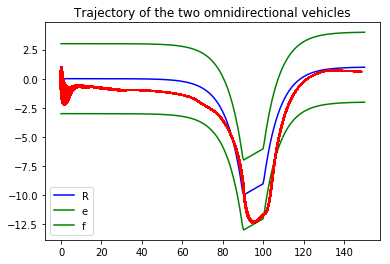

In [175]:
def draw_agent_traj(agent_trajs):
    plt.title("Trajectory of the two omnidirectional vehicles")
    plt.legend(["Vehicle", "Reference Path"])
    
    posx_ = np.asarray(x_nominal)[:, 0]
    posy_ = np.asarray(x_lane)[:, 1]
    posy_u = np.asarray(x_barrier_u)[:, 1]
    posy_l = np.asarray(x_barrier_l)[:, 1]
    _ = plt.plot(posx_, posy_, "b")
    _ = plt.plot(posx_, posy_u, 'g')
    _ = plt.plot(posx_, posy_l, 'g')
    _ = plt.legend("Reference Path")

    posx = []
    posy = []
    v = []
    theta = []
    for agent_traj in agent_trajs:
        posx.append([])
        posy.append([])
        v.append([])
        theta.append([])
        for j in agent_traj:
            posx[-1].append(j[0][0])
            posy[-1].append(j[0][1])
            v[-1].append(j[0][2])
            theta[-1].append(j[0][3])
            plt.plot(posx[-1], posy[-1], "r")

    plt.show()

draw_agent_traj(agent_traj)

In [180]:
N = len(x_nominal)
H = 2  # Number of time steps in trajectory.
n = 30
n_init = 0
#n_end = 250
n_end = N - H - 1

# Initial state.
x0s = [[x_nominal[0][0] + 0.5 * (2 * random.random() - 1.0), \
              x_nominal[0][1] + 1.0 * (2 * random.random() - 1.0), \
              x_nominal[0][2] + 0.5 * (2 * random.random() - 1.0), \
              x_nominal[0][3] + 0.5 * (2 * random.random() - 1.0)] for i in range(1)]
#x0s = [[0.39900493665079617, 0.8320303449982533, 10.396455344535626, -1.0767088538284288]]
#x0s = [[0.3988994445261298, 0.7324275040020252, 10.853930858105793, -1.5620640037718143]]
#x0s = [[0.19764148242052904, -0.3126818176457269, 10.953688935015933, -1.5028816289945062]]

# Random initial action path.
us_init = np.zeros((n - 1, dynamics.action_size))

J_hist = []

# Instantenous state cost.
Q = 0.0 * np.eye(dynamics.state_size)
Q[3, 3] = 0.0
Q[1, 1] = 0.0

R = np.eye(dynamics.action_size)
R[0, 0] = 0.0
R[1, 1] = 0.0


q = np.zeros((dynamics.state_size, 1))
r = np.zeros((dynamics.action_size, 1)) 
A = np.array([[[0, 1., 0, 0]], [[0, -1., 0, 0]]])
b = np.array([[-0.0], [0.0]])
q1 = [150.0, 10.0]
q2 = [150.0, 10.0]
#A = np.array([[[0, 1, 0, 0]]])
#b = np.array([11])

def MPSC(agent, x0s):
    train_traj = []
    nn_traj = []
    mpc_traj= []
    traj = []
    for num in range(len(x0s)):
        train_traj.append([])
        nn_traj.append([])
        mpc_traj.append([])
        traj.append([])
        x0 = x0s[num]
        for step in range(n_init, n_end):
            print(">>>>>Step {} at {}".format(step, x0))
            
            if ((x0 - barrier_u(x0)).dot(A[0].T) - b[0, 0] > 0) or \
            ((x0 - barrier_l(x0)).dot(A[1].T) - b[1, 0] > 0):
                return  traj, nn_traj, mpc_traj, train_traj 
            
            i = abs(int(x0[0]/0.5))
            if i > n_end:
                break
            x_nominal_ = x_nominal[i: i + H]
            x_nn = []
            for j in [x0] + x_nominal_[:]:
                for k in j:
                    x_nn.append(k)
            u = agent.run([x_nn])
            #print("NN outputs control")
            agent_traj[-1] = agent_traj[-1] + [[x0, u[0, :]]]
            x1 = dynamics.f(x0, u[0], i)[0]
            #print("Get next state")

            if i <= n_end - n - 1:
                n_ilqr =  n 
            elif n_end > i:
                n_ilqr = n_end - i
            else:
                break

            x0_ = x1[:]
            us_ = []
            xs_ = []
            for _ in range(n_ilqr):
                i_ = abs(int(x0_[0]/0.5))
                x_nn_ = []
                for j in [x0_] + x_nominal[i_ : i_ + H]:
                    for k in j:
                        x_nn_.append(k)
                while len(x_nn_) < 4 *(H + 1):
                    for k in x_nominal[-1]:
                        x_nn_.append(k)
                u_ = agent.run([x_nn_])
                xs_.append(x0_[:])
                us_.append(u_[0])
                x1_ = dynamics.f(x0_, u_[0], i_)[0][:]
                x0_ = x1_[:]
            xs_ = np.asarray(xs_)
            us_init = np.asarray(us_[:-1])
            
            if (np.squeeze(\
                    (xs_ - np.asarray([barrier_u(x) for x in xs_])).dot(A[0].T) - b[0,0]\
                               <= 0)).all() == True and \
                (np.squeeze(\
                    (xs_ - np.asarray([barrier_l(x) for x in xs_])).dot(A[1].T) - b[1,0]\
                               <= 0)).all() == True:
                traj[-1].append([x0, u[0, :]])
                nn_traj[-1].append(traj[-1][-1])
                #train_traj[-1].append([x_nn, u[0, :]])
                print("Utilize NN output {}".format(u))
            else: 
                x_nominal_ilqr = x_nominal[i + 1: i + 1 + n_ilqr]
                #us_init = np.random.uniform(-1, 1, (n_ilqr - 1, dynamics.action_size))


                cost_ = CarCost(Q = Q, q = q, \
                               R = R, r = r, \
                               A = A, b = b, \
                               q1 = q1, q2 = q2, \
                               x_nominal = x_nominal_ilqr[:], \
                               x_barrier_u = barrier_u,\
                               x_barrier_l = barrier_l)
                ilqr_ = iLQR(dynamics, cost_, n_ilqr - 1)
                try:
                    xs, us = ilqr_.fit(x1, us_init, on_iteration=on_iteration)
                except:
                    print(e)
                    return traj, nn_traj, mpc_traj, train_traj
                us = np.exp(-np.logaddexp(0, -us))
                #print("MPC verifying")


                if (np.squeeze(\
                    (xs - np.asarray([barrier_u(x) for x in xs])).dot(A[0].T) - b[0,0]\
                               <= 0)).all() == True and \
                    (np.squeeze(\
                    (xs - np.asarray([barrier_l(x) for x in xs])).dot(A[1].T) - b[1,0]\
                              <= 0)).all() == True:
                    traj[-1].append([x0, u[0, :]])
                    nn_traj[-1].append(traj[-1][-1])
                    train_traj[-1].append([x_nn, u[0, :]])
                    print("Utilize NN output {}".format(u))
                else:
                    max_itr = 0
                    while (np.squeeze(\
                    (xs - np.asarray([barrier_u(x) for x in xs])).dot(A[0].T) - b[0,0]\
                               <= 0)).all() == False or \
                    (np.squeeze(\
                    (xs - np.asarray([barrier_l(x) for x in xs])).dot(A[1].T) - b[1,0]\
                               <= 0)).all() == False :

                        if max_itr == 50:
                            #break
                            return  traj, nn_traj, mpc_traj, train_traj
                        max_itr += 1    
                        cost = CarCost(Q = Q, q = q, \
                               R = R, r = r, \
                               A = A, b = b, \
                               q1 = q1, q2 = q2, \
                               x_nominal = x_nominal_ilqr[:],\
                               x_barrier_u = barrier_u,\
                               x_barrier_l = barrier_l)
                        ilqr = iLQR(dynamics, cost, n_ilqr - 1)
                        xs, us = ilqr.fit(x0, us_init, n_iterations = max_itr * 10, on_iteration=on_iteration)
                        #us_init = us[:]# + 2 * np.random.random((n - 1, dynamics.action_size)) - 1.0
                        us_init = np.zeros((n - 1, dynamics.action_size))

                        us = np.exp(-np.logaddexp(0, -us))
                    traj[-1].append([x0, us[0]])
                    mpc_traj[-1].append(traj[-1][-1])
                    train_traj[-1].append([x_nn, us[0]])
                    x1 = dynamics.f(x0, us[0], i)[0]
                    print("Utilize MPC output {}".format(us[0]))
                    
            x0 = x1[:]
            
        return  traj, nn_traj, mpc_traj, train_traj
    
traj, nn_traj, mpc_traj, train_traj = MPSC(agent, x0s)


>>>>>Step 0 at [0.19764148242052904, -0.3126818176457269, 10.953688935015933, -1.5028816289945062]
Utilize NN output [[0.19893965 0.9480473 ]]
>>>>>Step 1 at [ 0.23482538 -0.85934856 10.96350674 -1.09819883]
Utilize NN output [[0.17330544 0.8732846 ]]
>>>>>Step 2 at [ 0.48445275 -1.34762878 10.97208629 -0.71281014]
Utilize NN output [[0.11334284 0.70250744]]
>>>>>Step 3 at [ 0.89959353 -1.70648757 10.97772929 -0.38037955]
Utilize NN output [[0.12281128 0.54973245]]
>>>>>Step 4 at [ 1.4093895  -1.91033096 10.98383916 -0.10576086]
Utilize NN output [[0.11797599 0.39287102]]
>>>>>Step 5 at [ 1.95565884 -1.96832125 10.98971075  0.09954504]
Utilize NN output [[0.11230819 0.25965893]]
>>>>>Step 6 at [ 2.50256324 -1.91369909 10.99530266  0.23910145]
Utilize NN output [[0.19649601 0.13077351]]
>>>>>Step 7 at [ 3.03692381 -1.78344093 11.00500294  0.31058911]
Utilize NN output [[0.18437879 0.04546188]]
>>>>>Step 8 at [ 3.56106351 -1.61520404 11.01411881  0.33558729]
Utilize NN output [[ 0.170756

Utilize NN output [[ 0.167912   -0.00143761]]
>>>>>Step 79 at [ 4.31975946e+01 -1.02962794e+00  1.14250189e+01 -1.15683610e-02]
Utilize NN output [[ 0.1513821  -0.00158388]]
>>>>>Step 80 at [ 4.37689951e+01 -1.03623841e+00  1.14325307e+01 -1.24731534e-02]
Utilize NN output [[ 0.13689394 -0.00098295]]
>>>>>Step 81 at [ 4.43407472e+01 -1.04337033e+00  1.14393329e+01 -1.30350320e-02]
Utilize NN output [[ 0.12384462 -0.00056747]]
>>>>>Step 82 at [ 4.49128193e+01 -1.05082773e+00  1.14454937e+01 -1.33596078e-02]
Utilize NN output [[ 0.11208457 -0.00030375]]
>>>>>Step 83 at [ 4.54851824e+01 -1.05847473e+00  1.14510746e+01 -1.35334378e-02]
Utilize NN output [[ 0.10147882 -0.00015271]]
>>>>>Step 84 at [ 4.60578101e+01 -1.06622482e+00  1.14561312e+01 -1.36208751e-02]
Utilize NN output [[0.1875143  0.00075876]]
>>>>>Step 85 at [ 4.66307952e+01 -1.07402987e+00  1.14653985e+01 -1.31862527e-02]
Utilize NN output [[ 0.1680652  -0.00212074]]
>>>>>Step 86 at [ 4.72042234e+01 -1.08159167e+00  1.14737236

iteration 0 accepted [903.94450658] [101.05253255 -10.53152043  11.99529993  -0.5691245 ] [6.2060132e+03 2.7991529e+00]
Utilize NN output [[ 0.02837506 -0.06934211]]
>>>>>Step 155 at [86.81428806 -6.21295385 11.78940355 -0.54562736]
iteration 0 accepted [-4349.90914216] [98.674899   -9.72976662 12.04078015 -1.73933389] [8.8596807e+03 5.1850595e+00]
Utilize NN output [[ 0.02753905 -0.07934608]]
>>>>>Step 156 at [87.3181977  -6.51887989 11.79078015 -0.5923016 ]
iteration 0 accepted [44981186.14737146] [101.53092334 -10.91776295  12.04214347  -1.34711499] [4340.838       4.633587]
iteration 0 accepted [-4349.99997298] [101.67728673  -7.33202047  11.24173424   0.72928145] [-385.42673     -0.3969827]
Utilize MPC output [1.        0.5710365]
>>>>>Step 157 at [87.80810326 -6.8485345  11.82885986 -0.28802867]
iteration 0 accepted [-4349.99998711] [96.15368667 -8.80018742 11.78008272 -4.05085996] [7122.6826      9.395558]
Utilize NN output [[ 0.02446212 -0.33764574]]
>>>>>Step 158 at [88.375211

iteration 0 accepted [-3879.76841579] [107.11287218  -3.99159652  12.08295462   0.20811208] [5.050967   0.03070483]
Utilize NN output [[ 0.02557284 -0.16139834]]
>>>>>Step 185 at [102.04955607  -8.86708152  12.00082608   0.36164078]
iteration 0 failed 528139.8506476005 [117.80118353  -0.66093538  12.02212556   0.19387394] [ 0.00972165 -0.02362042]
Utilize NN output [[ 0.02457531 -0.01698144]]
>>>>>Step 186 at [102.61081396  -8.65477043  12.0020546    0.35145219]
iteration 0 failed 527999.1680497458 [118.3910384   -0.54512323  12.02254021   0.18027603] [ 0.00829319 -0.02262532]
Utilize NN output [[0.02262222 0.06479105]]
>>>>>Step 187 at [103.17426122  -8.44816837  12.00318552   0.39027917]
iteration 0 failed 525701.0506605726 [118.98243237  -0.43733889  12.02289305   0.16750268] [ 0.00705693 -0.02125221]
iteration 0 failed 555280.0603019461 [ 1.18873842e+02 -1.61446438e+00  1.20218651e+01  1.06281309e-01] [ 0.00705693 -0.02125221]
Utilize MPC output [0. 1.]
>>>>>Step 188 at [103.729290

267


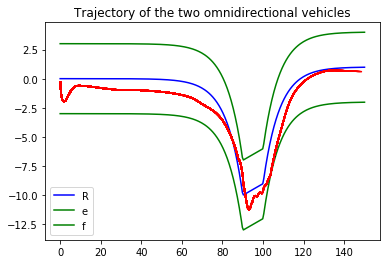

In [181]:
print(len(traj[0]))

draw_agent_traj(traj)
#pickle.dump((traj, nn_traj, mpc_traj, train_traj), open('safe_path_bk1.p', 'wb'))

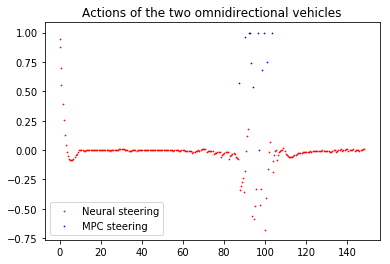

In [182]:
def draw_str(nn_traj, mpc_traj):
    str_nn = []
    posx_nn = []
    str_mpc = []
    posx_mpc = []
    for i in nn_traj[-1]:
        posx_nn.append(i[0][0])
        str_nn.append(i[1][1])
    for j in mpc_traj[-1]:
        posx_mpc.append(j[0][0])
        str_mpc.append(j[1][1])  

    _ = plt.title("Actions of the two omnidirectional vehicles")
    _ = plt.scatter(posx_nn, str_nn, s = 0.5, c = "r")
    _ = plt.scatter(posx_mpc, str_mpc, s = 0.5, c = "b")
    _ = plt.legend(["Neural steering", "MPC steering"])

draw_str(nn_traj, mpc_traj)

Now implement the MPSC guided controller. MPSC solves feasiblity problem to verify the safety of each output of the regression model. Once the output is unsafe, then MPC solves an optimal control and overrides the regression model.

The red curve in the plot is the trajecotry of the hybrid controller. It can be seen that the vehicle still drive out of the lane boundaries even with the existence of the MPSC. It is because horizon being 30 is too short to predict the unsafe outcome and prevent the vehicle from moving out of the boundary.

The red dots are the steering commands output by the regression model while the blue dots are from the MPC.

MPSC Guided Learning
=====================

I have considered two algorithms different from what we have discussed. Instead of filtering the learning-based controller's output during deploying phase, MPC can be used as a filter during training phase. The ultimate goal is that the learning model maintains high performance while avoiding performing unsafe behavior.

The basic set up is that the environment has state space $X$, control space $U$ as well as the known, perhaps nonlinear dynamics $x_{k+1} = f(x_k, u_k)$ where $x_k,u_k$ are current state and action pairs and $x_{k+1}$ is next state. Given a learning based controller $g:X\times \Theta\rightarrow U$ where $\Theta$ is the parameter space, a set of trajectories $\{\tau_i|\tau_i=(x^{(i)}_0, u^{(i)}_0, x^{(i)}_1, u^{(i)}_1, \ldots)\}$ can be obtained by executing $g$. Define the convex set of safe states $\{x|x\in X, UNSAFE(x)\leq 0\}$. Assume that an unsafe controller $g$ is at hand. It can generate at least one trajectory $\tau=(x_0, a_0, x_1, a_1, \ldots x_T, a_T\}$ that reaches an unsafe state.

In [183]:
def data_to_train(data_trajs):
    train_trajs = []
    for i_traj in range(len(data_trajs)):
        train_trajs.append([])
        for i_xy in range(len(data_trajs[i_traj])):
            train_trajs[i_traj].append([])
            x = data_trajs[i_traj][i_xy][0]
            i = abs(int(x[0]/0.5))
            x_nn = []
            for j in [x] + x_nominal[i : i + H]:
                for k in j:
                    x_nn.append(k)
            while len(x_nn) < 4 *(H + 1):
                for k in x_nominal[-1]:
                    x_nn.append(k)
            u = data_trajs[i_traj][i_xy][1][:]
            train_trajs[i_traj][i_xy] = [x_nn[:], u[:]] 
    return train_trajs

def train_pipeline(agent, x0s, train_trajs = None, paths = None, num_epoch = 100):

    
    #agent = NeuralNetwork(input_size = (n + 1) * 4, model_name = 'mlp_H2', batch_size = 1, checkpoint = 'checkpoints/mlp_H2_995.pt')
    
    X = []
    Y = []
    
    if train_trajs is not None and train_trajs is not []:
        print(len(train_trajs))
        for i_traj in range(len(train_trajs)):
            for i_xy in range(len(train_trajs[i_traj])):
                X.append([x for x in train_trajs[i_traj][i_xy][0]])
                Y.append([y for y in train_trajs[i_traj][i_xy][1]])
    if train_traj is not None or paths is not None:
        agent.data_process(X = X, Y = Y, paths = paths)
        
    n = int(np.asarray(X[0]).shape[0]/dynamics.state_size) - 1
    agent.train(num_epoch = num_epoch)
    #for i in range(len(X)):
    #    print(agent_.run([X[i]]), Y[i])

    agent_temp_traj = agent_run(agent, x0s)    
    draw_agent_traj(agent_temp_traj)
    
    # Random initial action path.
    us_init = np.zeros((n - 1, dynamics.action_size))

    J_hist = []
    q1 = [100.0, 10.0]
    q2 = [100.0, 10.0]

    trajs_, nn_trajs_, mpc_trajs_, train_trajs_ = MPSC(agent, x0s)
    draw_agent_traj(trajs_)
    draw_str(nn_trajs_, mpc_trajs_)
    return trajs_, nn_trajs_, mpc_trajs_, train_trajs_ 


1
35
[Epoch 1] avg_loss: 0.227
[Epoch 51] avg_loss: 0.157
Finished Training


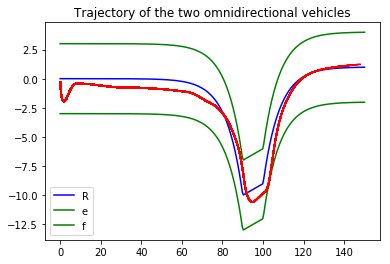

>>>>>Step 0 at [0.19764148242052904, -0.3126818176457269, 10.953688935015933, -1.5028816289945062]
Utilize NN output [[0.19196801 0.9464948 ]]
>>>>>Step 1 at [ 0.23482481 -0.85934019 10.96317114 -1.09858532]
Utilize NN output [[0.16438814 0.86851877]]
>>>>>Step 2 at [ 0.48425089 -1.34769226 10.9713173  -0.71453405]
Utilize NN output [[0.11253096 0.7171166 ]]
>>>>>Step 3 at [ 0.89874261 -1.70724033 10.97692022 -0.37710017]
Utilize NN output [[0.12589616 0.5882828 ]]
>>>>>Step 4 at [ 1.40917024 -1.90939731 10.98318198 -0.08694753]
Utilize NN output [[0.12224383 0.42911464]]
>>>>>Step 5 at [ 1.95640633 -1.9570984  10.98926391  0.13523189]
Utilize NN output [[0.1198981 0.29321  ]]
>>>>>Step 6 at [ 2.50100078 -1.88299962 10.99523025  0.29187649]
Utilize NN output [[0.2138182  0.14185107]]
>>>>>Step 7 at [ 3.0277626  -1.72473007 11.00576116  0.36934186]
Utilize NN output [[0.20326507 0.0436749 ]]
>>>>>Step 8 at [ 3.54117579 -1.52598463 11.01578672  0.39336037]
Utilize NN output [[ 0.19077416

Utilize NN output [[0.14710042 0.00036953]]
>>>>>Step 82 at [ 4.49906265e+01 -8.33291693e-01  1.15409021e+01 -9.64550421e-03]
Utilize NN output [[0.1330693  0.00036959]]
>>>>>Step 83 at [ 4.55678101e+01 -8.38859093e-01  1.15475166e+01 -9.43223212e-03]
Utilize NN output [[ 0.23682931 -0.0023878 ]]
>>>>>Step 84 at [ 4.61454508e+01 -8.44307696e-01  1.15591415e+01 -1.08108889e-02]
Utilize NN output [[ 0.21318851 -0.00139926]]
>>>>>Step 85 at [ 4.67236367e+01 -8.50558642e-01  1.15696423e+01 -1.16196022e-02]
Utilize NN output [[ 0.19190139 -0.00071691]]
>>>>>Step 86 at [ 4.73023167e+01 -8.57282977e-01  1.15791213e+01 -1.20343215e-02]
Utilize NN output [[ 0.17275317 -0.00028048]]
>>>>>Step 87 at [ 4.78814446e+01 -8.64252725e-01  1.15876741e+01 -1.21967097e-02]
Utilize NN output [[ 1.5554342e-01 -3.2767653e-05]]
>>>>>Step 88 at [ 4.84609781e+01 -8.71321477e-01  1.15953891e+01 -1.22156948e-02]
Utilize NN output [[1.4007448e-01 7.1242452e-05]]
>>>>>Step 89 at [ 4.90408782e+01 -8.78405712e-01  1.

Utilize NN output [[ 0.08212326 -0.09705469]]
>>>>>Step 157 at [88.5570311  -6.48449431 12.06710349 -0.71422814]
Utilize NN output [[ 0.08908956 -0.09141999]]
>>>>>Step 158 at [89.01300962 -6.87978545 12.07154622 -0.76923371]
Utilize NN output [[ 0.09779899 -0.09496219]]
>>>>>Step 159 at [89.44673361 -7.29970948 12.07642064 -0.82637905]
Utilize NN output [[ 0.04059366 -0.00641017]]
>>>>>Step 160 at [89.85588289 -7.7438468  12.0784492  -0.8302496 ]
Utilize NN output [[ 0.04475512 -0.21911082]]
>>>>>Step 161 at [90.26338199 -8.18964311 12.08068547 -0.96049779]
Utilize NN output [[0.05314806 0.16560973]]
>>>>>Step 162 at [90.6095994  -8.68468967 12.08334037 -0.86136845]
Utilize NN output [[0.07415583 0.21528234]]
>>>>>Step 163 at [91.00321394 -9.14316234 12.08704138 -0.73327477]
Utilize NN output [[0.09521655 0.23556313]]
>>>>>Step 164 at [91.45232757 -9.54773843 12.09178787 -0.59348778]
Utilize NN output [[0.05165834 0.213499  ]]
>>>>>Step 165 at [91.95358274 -9.88589462 12.0943685  -0.4

Utilize NN output [[ 0.01671586 -0.00089039]]
>>>>>Step 228 at [1.27069279e+02 7.03273089e-01 1.22528996e+01 5.30998023e-02]
Utilize NN output [[ 0.03095558 -0.01322742]]
>>>>>Step 229 at [1.27681099e+02 7.35791184e-01 1.22544469e+01 4.49965613e-02]
Utilize NN output [[ 0.0256198  -0.00605863]]
>>>>>Step 230 at [1.28293233e+02 7.63353720e-01 1.22557276e+01 4.12843464e-02]
Utilize NN output [[ 0.02125487 -0.00173582]]
>>>>>Step 231 at [1.28905524e+02 7.88646116e-01 1.22567902e+01 4.02206609e-02]
Utilize NN output [[0.01766233 0.00060169]]
>>>>>Step 232 at [1.29517890e+02 8.13289169e-01 1.22576732e+01 4.05894026e-02]
Utilize NN output [[ 0.03263955 -0.01224327]]
>>>>>Step 233 at [1.30130309e+02 8.38160575e-01 1.22593046e+01 3.30860774e-02]
Utilize NN output [[ 0.02698014 -0.00431542]]
>>>>>Step 234 at [1.30742973e+02 8.58438606e-01 1.22606533e+01 3.04408891e-02]
Utilize NN output [[0.02236823 0.00030027]]
>>>>>Step 235 at [1.31355749e+02 8.77097834e-01 1.22617715e+01 3.06249665e-02]
Util

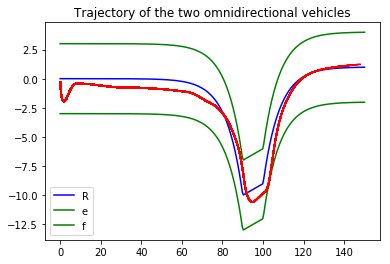

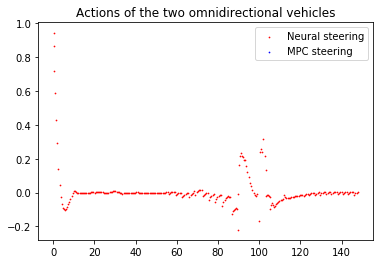

In [186]:
H = 2 
agent_ = NeuralNetwork(input_size = (H + 1) * dynamics.state_size, model_name = 'mlp_temp_H2_temp', batch_size = 500, checkpoint = 'checkpoints/mlp_H2.pt')
paths = ['expert_traj/expert_pts_10058_H10.p', 'expert_traj/expert_pts_17358_H10.p']

train_traj_aggr = train_traj

trajs_, nn_trajs_, mpc_trajs_, train_trajs_  = train_pipeline(agent_, x0s, train_traj_aggr, paths = None)





In [ ]:
# Keep training
"""
#raise TypeError
itr_train = 2
batch_size = 3




while itr_train < batch_size:
    # Initial state.
    agent_ = NeuralNetwork(input_size = (H + 1) * dynamics.state_size, model_name = 'mlp_temp_H2', batch_size = 500, checkpoint = 'checkpoints/mlp_temp_H2.pt')
    train_traj_aggr = train_traj_aggr + int((batch_size - itr_train) * 120 + 1) * train_traj_[:]
    trajs_, nn_trajs_, mpc_trajs_, train_trajs_  = train_pipeline(agent_, x0s[:itr_train], train_traj_aggr, paths = None) 
    itr_train += 1
    
    x0s = [[x_nominal[0][0] + 0.5 * (2 * random.random() - 1.0), \
                  x_nominal[0][1] + 1.0 * (2 * random.random() - 1.0), \
                  x_nominal[0][2] + 0.5 * (2 * random.random() - 1.0), \
                  x_nominal[0][3] + 0.5 * (2 * random.random() - 1.0)]]
"""

Done


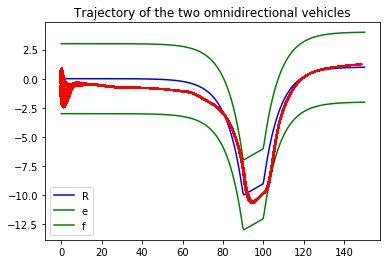

In [187]:
#x0s = []
batch_size = 20
for i_batch in range(batch_size):
    
    x0s.append([x_nominal[0][0] + 0.5 * (2 * random.random() - 1.0), \
          x_nominal[0][1] + 1.0 * (2 * random.random() - 1.0), \
          x_nominal[0][2] + 0.5 * (2 * random.random() - 1.0), \
          x_nominal[0][3] + 0.5 * (2 * random.random() - 1.0)])  # Initial state.
    
N = 300
H = 2
agent_traj_ = agent_run(agent_, x0s)
        

print("Done")
draw_agent_traj(agent_traj_)

<h2>MPSC Guided Policy Search</h2>

The algorithm is inspired by the motivation of iLQR, which is to linearize the nonlinear dynamics. Given one trajectory $\tau$, a perturbation can be added to this trajectory, i.e. $x_k\rightarrow x_k + \delta x_k, u_k\rightarrow u_k +\delta u_k$. Then the relationship between $\delta x_k,\delta u_k$ can be obtained as follows.

\begin{eqnarray}
x_{k+1} &=& f(x_k, u_k)\\
x_{k+1} \delta x_{k+1} &=& f(x_k+\delta x_k, u_k + \delta u_k) \\
\delta x_{k+1} &=& f(x_k+\delta, u_k + \delta u_k) - f(x_k, u_k)\\
&\approx& \nabla_x f(x_k, u_k) \delta x_k + \nabla_u f(x_k, u_k) \delta u_k
\end{eqnarray}


Usually, learning-based controller upates its model parameter iteratively during the training phase. We can use MPSC to filter the update. It is already known that $u_k=\pi(x_k; \theta)$.Then the following equation holds.

\begin{eqnarray}
u_k &=& \pi(x_k; \theta)\\
u_k + \delta u_k &=& \pi(x_k + \delta x_k; \theta + \delta \theta)\\
\delta u_k &\approx& \nabla_x \pi(x_k; \theta) \delta x_k + \nabla_\theta \pi(x_k; \theta) \delta \theta
\end{eqnarray}

Then interpolate it into the linearized dynmics. 
$$\delta x_{k+1} \approx [\nabla_x f(x_k, u_k)  + \nabla_u f(x_k, u_k) \nabla_x \pi(x_k; \theta) ]\delta x_k + \nabla_u f(x_k, u_k) \nabla_\theta \pi(x_k; \theta) \delta \theta$$


At this end, we can determine our MPSC problem as, finding the minimal perturbation on the learning model parameters such that the unsafe trajecotries becomes safe.

Previously, we used L-2 norm of the perturbation on the model parameters, i.e. $||\delta \theta||^2_2$, to estimate the loss $L(\delta\theta)$. The optimization problem is as follows.

\begin{eqnarray}
\underset{\delta\theta}{min}&&||\delta \theta||_2^2 \\
s.t. && \delta x_{k+1} = [\nabla_x f(x_k, u_k)  + \nabla_u f(x_k, u_k) \nabla_x \pi(x_k; \theta) ]\delta x_k + \nabla_u f(x_k, u_k) \nabla_\theta \pi(x_k; \theta) \delta \theta\qquad k=0, 1, 2, \ldots, T\\
&& \delta x_0 = 0\\
&& UNSAFE(x_k+\delta x_k)\leq 0\qquad k=0, 1, 2, \ldots, T
\end{eqnarray}

It is a typical Quadratic Programming problem especially if the constrains are all convex. But it would be extremely computationally expensive for traditional QP solver because the size of $\nabla_\theta \pi(x; \theta)$ can be immensively large. 

Considering the difficulty, we can alternate the problem in the following way.

Firstly, given the current model parameter $\theta_i$, the linearization of the perturbation on the learning model can be rearranged in the following way.

$$\delta \theta_i^T \nabla_\theta \pi(x_k; \theta_i) \approx \delta u_k^T -\delta x_k^T \nabla_x \pi(x_k; \theta_i)$$

Let the optimal control at state $x_k$ be $u^*_k$, which can be presumably obtained with the initial model parametere $\theta_0$, i.e. $u^*_k= \pi(x_k; \theta_0)$. The loss of the model based on this specific data point can be evaluated by using square error  
$$J_{(x_k, u^*_k)}(\theta_i) = ||\pi(x_k; \theta_i) - u^*_k||^2_2$$ 
or log likelihood with fixed covariance $\Sigma$
$$J_{(x_k, u^*_k)}(\theta_i) = -log[\frac{1}{(2\pi)^{\frac{n}{2}}\Sigma} exp\{-\frac{1}{2}[\pi(x_k; \theta_i) - u^*_k]^T \Sigma^{-1}[\pi(x_k,\theta_i)-u^*_k]\}$$

Either way, up to a scale of constant, $\nabla_\theta J_{(x_k, u^*_k)}(\theta_i)= \nabla_\theta \pi(x_k; \theta_i)[\pi(x_k; \theta_i) - u^*_k]$.

Evaluating the loss of the model based on a set $D=\{\tau = (x_0, u^*_0, \ldots, x_k, u^*_k, \ldots)\}$ of trajectories sampled from the roll-out of the unchanged model, then the increase on the model's loss due to the perturbation is $J_{D}(\theta_i+\delta\theta_i) - J_{D}(\theta_i)\approx \delta\theta_i^T \nabla_\theta J_{D}(\theta_i) + \frac{1}{2}\delta\theta_i^T \nabla^2_\theta J_{D}(\theta_i)\delta\theta_i$ and it is to be minimized.

Using Fisher Information Matrix to replace the second order derivative, the increase of loss turns out to be
\begin{eqnarray}
&&\delta\theta_i^T \mathbb{E}_{(x_k, u^*_k)\sim D}[\nabla_\theta J_{(x_k, u^*_k)}(\theta_i)] + \frac{1}{2}\delta\theta_i^T \mathbb{E}_{(x_k, u^*_k)\sim D}[\nabla_\theta J_{(x_k, u^*_k)}(\theta_i) \nabla_\theta  J_{(x_k, u^*_k)}(\theta_i)^T]\delta\theta_i\\
&=&\mathbb{E}_{(x_k, u^*_k)\sim D} [\delta\theta_i^T\nabla_\theta J_{(x_k, u^*_k)}(\theta_i)] + \frac{1}{2}\mathbb{E}_{(x_k, u^*_k)\sim D}[\delta\theta_i^T \nabla_\theta J_{(x_k, u^*_k)}(\theta_i) \nabla_\theta  J_{(x_k, u^*_k)}(\theta_i)^T\delta\theta_i]\\
&=&\mathbb{E}_{(x_k, u^*_k)\sim D} \{\delta\theta_i^T\nabla_\theta \pi(x_k; \theta_i)[\pi(x_k; \theta_i) - u^*_k]\} + \frac{1}{2}\mathbb{E}_{(x_k, u^*_k)\sim D}\{\delta\theta_i^T \nabla_\theta \pi(x_k; \theta_i)[\pi(x_k; \theta_i) - u^*_k] [\pi(x_k; \theta_i) - u^*_k]^T\nabla_\theta \pi(x_k; \theta_i)^T\delta\theta_i\}\\
&\approx& \mathbb{E}_{(x_k, u^*_k)\sim D}\{[\delta u_k -\delta x_k^T \nabla_x \pi(x_k; \theta_i)][\pi(x_k; \theta_i) - u^*_k]\}+ \frac{1}{2}\mathbb{E}_{(x_k, u^*_k)\sim D}\{[\delta u_k^T -\delta x_k^T \nabla_x \pi(x_k; \theta_i)][\pi(x_k; \theta_i) - u^*_k] [\pi(x_k; \theta_i) - u^*_k]^T[\delta u_k^T -\delta x_k^T \nabla_x \pi(x_k; \theta_i)]^T\}\\
&\approx& \frac{1}{4|D|} \sum_{(x_k, u^*_k)\in D} \\
&&\begin{bmatrix} 1\\\delta x_k \\ \delta u_k\end{bmatrix}^T 
\begin{bmatrix} 
0 &-2[\pi(x_k; \theta_i) - u^*_k]^T\nabla_x \pi(x_k; \theta_i)^T &  2[\pi(x_k; \theta_i) - u^*_k]^T\\ 
-2\nabla_x \pi(x_k; \theta_i)[\pi(x_k; \theta_i) - u^*_k] & \nabla_x \pi(x_k; \theta_i) [\pi(x_k; \theta_i) - u^*_k][\pi(x_k; \theta_i) - u^*_k]^T \nabla_x \pi(x_k; \theta_i)^T & \nabla_x \pi(x_k; \theta_i) [\pi(x_k; \theta_i) - u^*_k][\pi(x_k; \theta_i) - u^*_k]^T \\
2[\pi(x_k; \theta_i) - u^*_k] & [\pi(x_k; \theta_i) - u^*_k][\pi(x_k; \theta_i) - u^*_k]^T \nabla_x \pi(x_k; \theta_i)^T & [\pi(x_k; \theta_i) - u^*_k][\pi(x_k; \theta_i) - u^*_k]^T 
\end{bmatrix} 
\begin{bmatrix}1\\\delta x_k \\ \delta u_k\end{bmatrix} 
\end{eqnarray}

As a result, we get a quadratic objective function of which the variables are only $\delta x$ and $\delta u$. As $\pi(,)$ is considered, variable $\delta\theta$ is implicit in this objective function. After solving the $\delta x$ and $\delta u$, $\delta\theta$ can be directly derived and used to modify $\theta_i$. One thing to be stressed is that $\pi(x_k;\theta_i + \delta\theta_i)\neq u_k + \delta u_k$ because $\delta u_k$ is induced by both $\delta x_k$ and $\delta \theta_i$.

If we choose to directly constrain the trajectory, the $UNSAFE()$ function can be rewritten as a barrier function $b:X\rightarrow \mathbb{R}^+$ such that $UNSAFE(x)\leq \Rightarrow b(x)\approx 0$ and $UNSAFE(x)\geq 0 \Rightarrow b(x)\approx \infty$. One candidate is the exponential. Linearize $b$ in the same way as LQR.
\begin{eqnarray}
b(x_k + \delta x_k) = b(x_k) + \delta x_k^T \nabla_x b(x_k) + \delta x_k^T \nabla_x b(x_k) \delta x_k
\end{eqnarray}

For instance, $b(x) = w_1 exp[w_2*UNSAFE(x)]$, the barrier can be written as follows. It can be added to the objective. 
$$b(x_k+\delta x_k) = b(x_k) + \delta x_k^T w_1w_2 exp[w_2 UNSAFE(x)]\nabla_x UNSAFE(x) ^T + \delta x_k^T \{w_1 w_2exp[w_2 UNSAFE(x)]\nabla_{x,x} UNSAFE(x)  + w_1 w_2^2  exp[w_2 UNSAFE(x)]\nabla_x UNSAFE(x) \nabla_x UNSAFE(x)^T\}\delta_x$$

Actually, this constraint will not be needed to be directly enforced in the optimization if the following procedure works.

Firstly we need an initially feasible solution $\delta {\bf x}$ and $\delta {\bf u}$ to ensure the safety of ${\bf x} + \delta{\bf x}$. In fact they can be directly obtained by using MPSC. Once MPSC overrides the learning based controller and invokes a $\delta u_k=u_k^{safe} - u_k$, a safe trajectory ${\bf x} + \delta{\bf x}$ can be obtained in the end. To get $\delta {\bf x}$, the original unsafe trajectory ${\bf x}$ can be simulated at the very first time when MPSC is involved. From the feasible solution, the first feasible $\delta \theta_1$ can be obtained. Henceforth, an iLQR style backward and forward pass can be implemented. 

It is known that the optimal $\delta {\bf u}$ is affine in $\delta {\bf x}$, i.e. $\delta {\bf u} = k + K \delta {\bf x}$. Likewise, $\delta\theta^T \nabla_\theta \pi(x;\theta) = k^T + \delta {\bf x}^T [K^T + \nabla_x \pi(x; \theta)]$ in which $k, K$ should be updated via backward pass while $\delta \theta$ is updated at the end of the forward pass.  

During the forward pass, MPSC should keep monitoring and intervene when necessary. Therefore, the resulted trajectory after a forward pass may not be exctly be induced from the optimal solution. The iteration goes on with safety guarantee and terminates when the changes on $\delta \theta$ and $\delta {\bf x}$ are trivia.

**Initialization**

1. Learning based controller $\pi(;\theta_0)$
2. MPSC verifier

**Iteration** $i$

1. Run $\pi(;\theta_i)$ and the safe controller to generate a safe trajectory $\tau_i$. Train the learning model using $\tau_i$ with an online scheme to obtain $\hat{\theta_i}$ such that all $u$'s in the trajectory equals the outputs of $\pi(;\hat{\theta_i})$ despite some of them are originally generated by the MPSC.
2. Run $\pi(;\theta_0)$ at every state in the trajectory to obtain $u^*$'s.
3. Solve the QP to find $\delta x$'s and $\delta u$'s that should be applied to this trajectory. 
4. Solve $\delta \theta_i$ and add to $\theta_i$ to obtain $\theta_{i+1}$.



In [188]:
import torch.utils.data as data_utils
import torch.nn as nn
import torch.nn.functional as F
import torch

from torch.autograd import Variable
from scipy.linalg import block_diag

from scipy.sparse import coo_matrix, vstack, linalg
from cvxopt import spmatrix, spdiag, matrix, solvers, sparse

n = 2
checkpoint_0 = 'checkpoints/mlp_H2.pt'
paths = ['expert_traj/expert_pts_10058_H10.p', 'expert_traj/expert_pts_17358_H10.p']
epoch_init = 0
num_epoch = 10
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

def numpy_sparse_to_spmatrix(X):
    X = coo_matrix(X)
    coo = X.tocoo()
    SP = spmatrix(coo.data.tolist(), coo.row.tolist(), coo.col.tolist(), size = coo.shape)
    return SP

In [158]:
agent_0 = NeuralNetwork(input_size = (n + 1) * 4, \
                      model_name = 'mlp_H2_MPSC_0', \
                      batch_size = 1000, \
                      checkpoint = checkpoint_0)

agent_0.data_process(paths = paths)

if checkpoint_0 is not None:
    checkpoint = torch.load(checkpoint_0, map_location=device)
    agent_0.model.load_state_dict(checkpoint['model_state_dict'])
    agent_0.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch_init = checkpoint['epoch'] + 1
    loss = checkpoint['loss']
    agent_0.model.eval()
    loss.backward()
    agent_0.optimizer.step()

27416


Done. 5 paths


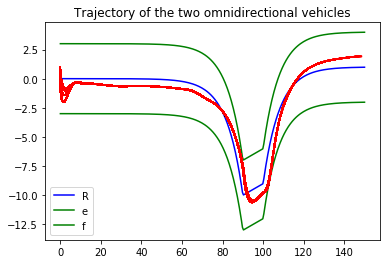

In [189]:
x0s = []
batch_size = 5
for i_batch in range(batch_size):
    x0s.append([x_nominal[0][0] + 0.1 * (2 * random.random() - 1.0), \
          x_nominal[0][1] + 1.0 * (2 * random.random() - 1.0), \
          x_nominal[0][2] + 0.1 * (2 * random.random() - 1.0), \
          x_nominal[0][3] + 0.1 * (2 * random.random() - 1.0)])  # Initial state.

agent = NeuralNetwork(input_size = (n + 1) * 4, \
                      model_name = 'mlp_H2_MPSC', \
                      batch_size = 1000, \
                      checkpoint = 'checkpoints/mlp_temp_H2_temp.pt')
'''
# Run MPSC guided controller and generate safe trajectory
traj, nn_traj, mpc_traj, train_traj = MPSC(agent, x0s)
draw_agent_traj(traj)
draw_str(nn_traj, mpc_traj)

# Collect training trajectory
train_traj_aggr = [i for i in train_traj[:]] * 100
itr = 0

while itr < 1:
    train_traj = train_temp(agent, x0s, train_traj_aggr, paths = None)
    train_traj_aggr = train_traj_aggr + [i for i in train_traj[:]] * 100
    itr += 1
'''

agent_traj = agent_run(agent, x0s) 
print("Done. {} paths".format(len(agent_traj)))
draw_agent_traj(agent_traj)


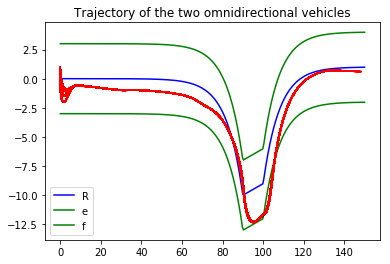

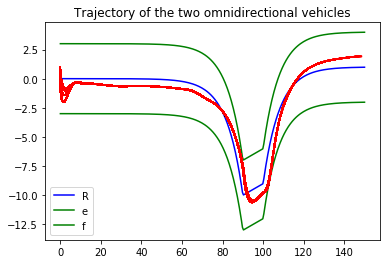

>>>>>>>>>>>>>>>>>>>>
Start epoch 0
Optimize rajectory 0
Finished iteration 0 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 40 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 50 [Unsafe]
Finished iteration 60 [Unsafe]
Finished iteration 70 [Unsafe]
Finished iteration 80 [Unsafe]
Finished iteration 90 [Unsafe]
Found new optimal solution. Load QP parameters.


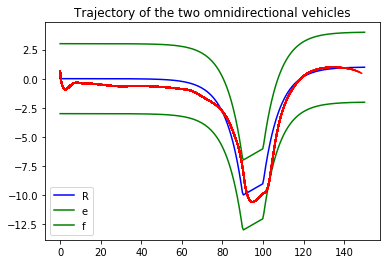

Optimize rajectory 1
Finished iteration 0 [Unsafe]
Finished iteration 10 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 20 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 40 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 50 [Unsafe]
Finished iteration 60 [Unsafe]
Finished iteration 70 [Unsafe]
Finished iteration 80 [Unsafe]
Finished iteration 90 [Unsafe]


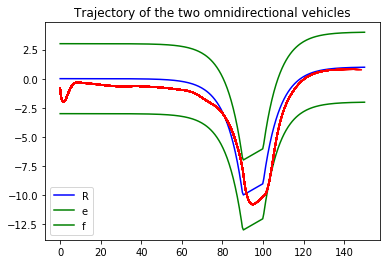

Optimize rajectory 2
Finished iteration 0 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 40 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 50 [Unsafe]
Finished iteration 60 [Unsafe]
Finished iteration 70 [Unsafe]
Finished iteration 80 [Unsafe]
Finished iteration 90 [Unsafe]
Found new optimal solution. Load QP parameters.


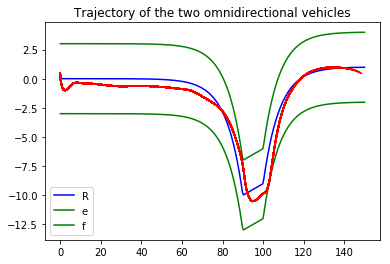

Optimize rajectory 3
Finished iteration 0 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 40 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 50 [Unsafe]
Finished iteration 60 [Unsafe]
Finished iteration 70 [Unsafe]
Finished iteration 80 [Unsafe]
Finished iteration 90 [Unsafe]
Found new optimal solution. Load QP parameters.


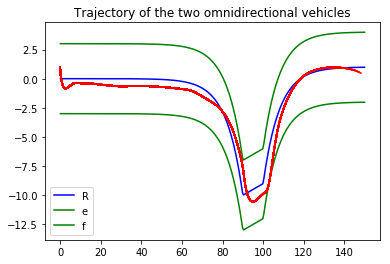

Optimize rajectory 4
Finished iteration 0 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 40 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 50 [Unsafe]
Finished iteration 60 [Unsafe]
Finished iteration 70 [Unsafe]
Finished iteration 80 [Unsafe]
Finished iteration 90 [Unsafe]
Found new optimal solution. Load QP parameters.


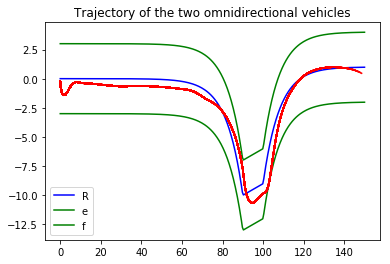

5
1315
[Epoch 1] avg_loss: 0.003
[Epoch 51] avg_loss: 0.001
Finished Training


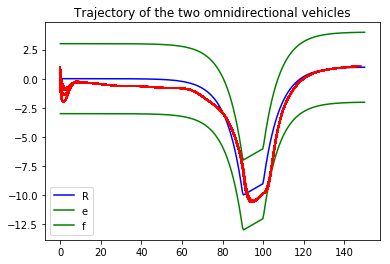

>>>>>Step 0 at [0.009178715132125759, 0.6459653324573957, 11.054699039462248, -1.1798340465846398]
Utilize NN output [[0.09453267 0.64565253]]
>>>>>Step 1 at [ 0.21985889  0.1348293  11.05941164 -0.86547378]
Utilize NN output [[0.07955705 0.53971314]]
>>>>>Step 2 at [ 0.57840269 -0.28627944 11.06338112 -0.59298602]
Utilize NN output [[0.10179435 0.446199  ]]
>>>>>Step 3 at [ 1.03723748 -0.59548316 11.06845333 -0.36133565]
Utilize NN output [[0.11421023 0.3537353 ]]
>>>>>Step 4 at [ 1.55505611 -0.79118158 11.07413915 -0.17334681]
Utilize NN output [[0.11954709 0.27287883]]
>>>>>Step 5 at [ 2.10061117 -0.88671059 11.08008819 -0.02589379]
Utilize NN output [[0.11758715 0.19303252]]
>>>>>Step 6 at [ 2.65457613 -0.90105805 11.0859406   0.07973832]
Utilize NN output [[0.11152596 0.12110187]]
>>>>>Step 7 at [ 3.20725031 -0.8568951  11.09149389  0.14653849]
Utilize NN output [[0.10401452 0.05904854]]
>>>>>Step 8 at [ 3.75600948 -0.77590018 11.09667594  0.1792473 ]
Utilize NN output [[0.0952938

Utilize NN output [[ 0.15997975 -0.01481527]]
>>>>>Step 129 at [73.10986969 -1.91071328 11.97618275 -0.12580152]
Utilize NN output [[ 0.13699843 -0.00424705]]
>>>>>Step 130 at [73.70411553 -1.98586719 11.98299014 -0.12834468]
Utilize NN output [[0.11761681 0.0022965 ]]
>>>>>Step 131 at [74.29848225 -2.06257263 11.98884401 -0.12696873]
Utilize NN output [[0.10110875 0.00556796]]
>>>>>Step 132 at [74.89322406 -2.13849467 11.99388229 -0.1236311 ]
Utilize NN output [[0.08694539 0.00631061]]
>>>>>Step 133 at [75.48844853 -2.21246015 11.99821864 -0.11984671]
Utilize NN output [[0.07483945 0.00522399]]
>>>>>Step 134 at [76.08414899 -2.28419668 12.00195364 -0.11671281]
Utilize NN output [[ 0.12784691 -0.03805581]]
>>>>>Step 135 at [76.68032194 -2.35409537 12.00831139 -0.139539  ]
Utilize NN output [[ 0.10893859 -0.02644251]]
>>>>>Step 136 at [77.27503593 -2.437624   12.01373687 -0.15541179]
Utilize NN output [[ 0.09328582 -0.01810586]]
>>>>>Step 137 at [77.86859809 -2.53062048 12.01838768 -0.1

Utilize NN output [[0.01226822 0.00286226]]
>>>>>Step 259 at [1.46853389e+02 1.06941926e+00 1.22978942e+01 1.01068985e-02]
Utilize NN output [[0.01024079 0.00668813]]
>>>>>Step 260 at [1.47468266e+02 1.07563396e+00 1.22984062e+01 1.42193330e-02]
Utilize NN output [[0.00855818 0.00874592]]
>>>>>Step 261 at [1.48083134e+02 1.08437757e+00 1.22988341e+01 1.95972379e-02]
Utilize NN output [[ 0.01526718 -0.0073356 ]]
>>>>>Step 262 at [1.48697977e+02 1.09642833e+00 1.22995974e+01 1.50863536e-02]


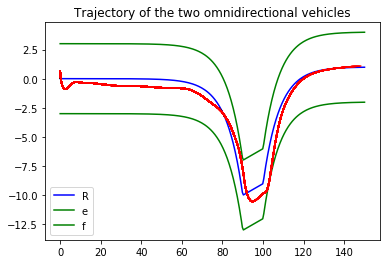

No intervention. Agent is clear.


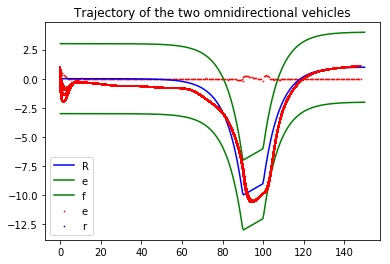

<<<<<<<<<<<<<<<<<<<<
Finished epoch 0




>>>>>>>>>>>>>>>>>>>>
Start epoch 1
Optimize rajectory 0
Finished iteration 0 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 40 [Unsafe]
Finished iteration 50 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 60 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 70 [Unsafe]
Finished iteration 80 [Unsafe]
Finished iteration 90 [Unsafe]


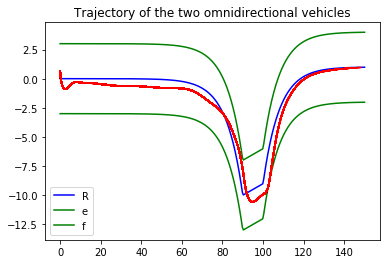

Optimize rajectory 1
Finished iteration 0 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 30 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 40 [Unsafe]
Finished iteration 50 [Unsafe]
Finished iteration 60 [Unsafe]
Finished iteration 70 [Unsafe]
Finished iteration 80 [Unsafe]
Finished iteration 90 [Unsafe]


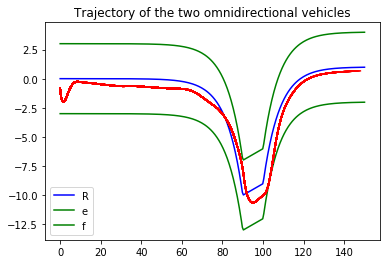

Optimize rajectory 2
Finished iteration 0 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 40 [Unsafe]
Finished iteration 50 [Unsafe]
Finished iteration 60 [Unsafe]
Finished iteration 70 [Unsafe]
Finished iteration 80 [Unsafe]
Finished iteration 90 [Unsafe]


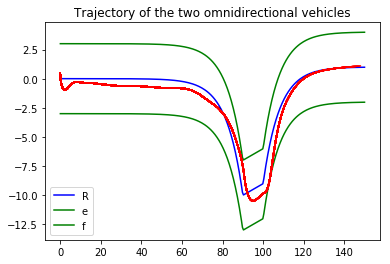

Optimize rajectory 3
Finished iteration 0 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 30 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 40 [Unsafe]
Finished iteration 50 [Unsafe]
Finished iteration 60 [Unsafe]
Finished iteration 70 [Unsafe]
Finished iteration 80 [Unsafe]
Finished iteration 90 [Unsafe]


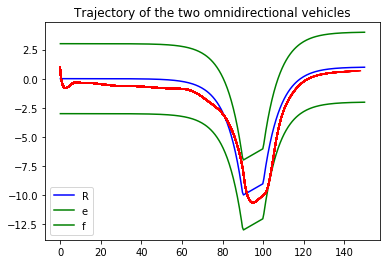

Optimize rajectory 4
Finished iteration 0 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 40 [Unsafe]
Finished iteration 50 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 60 [Unsafe]
Finished iteration 70 [Unsafe]
Finished iteration 80 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 90 [Unsafe]


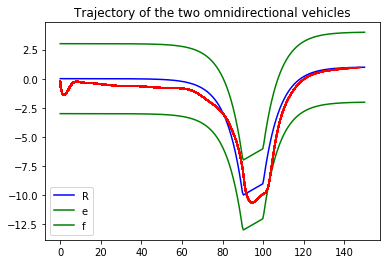

5
1310
[Epoch 1] avg_loss: 0.000
[Epoch 51] avg_loss: 0.000
Finished Training


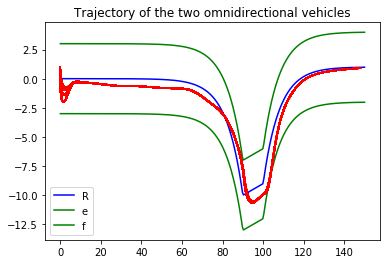

>>>>>Step 0 at [0.009178715132125759, 0.6459653324573957, 11.054699039462248, -1.1798340465846398]
Utilize NN output [[0.09417876 0.6474335 ]]
>>>>>Step 1 at [ 0.21985872  0.1348297  11.0593941  -0.86480846]
Utilize NN output [[0.07915758 0.5407417 ]]
>>>>>Step 2 at [ 0.57868172 -0.28603935 11.06334374 -0.59189071]
Utilize NN output [[0.10123153 0.446731  ]]
>>>>>Step 3 at [ 1.03785279 -0.59473889 11.06838809 -0.3599985 ]
Utilize NN output [[0.11341529 0.35387242]]
>>>>>Step 4 at [ 1.55592866 -0.78974323 11.07403467 -0.17194364]
Utilize NN output [[0.11869419 0.272874  ]]
>>>>>Step 5 at [ 2.10161105 -0.88450556 11.07994166 -0.02449449]
Utilize NN output [[0.11673722 0.19287425]]
>>>>>Step 6 at [ 2.65558716 -0.89807764 11.08575216  0.08105172]
Utilize NN output [[0.11071859 0.12081347]]
>>>>>Step 7 at [ 3.20819249 -0.85318969 11.09126557  0.14769322]
Utilize NN output [[0.10311189 0.05888846]]
>>>>>Step 8 at [ 3.75684536 -0.771563   11.09640297  0.1803129 ]
Utilize NN output [[0.0944809

Utilize NN output [[ 0.15980378 -0.01416542]]
>>>>>Step 129 at [73.10452526 -1.96299134 11.9763287  -0.13396208]
Utilize NN output [[ 0.13698125 -0.00296217]]
>>>>>Step 130 at [73.69814523 -2.04299304 11.98313524 -0.13573587]
Utilize NN output [[0.11773744 0.00392857]]
>>>>>Step 131 at [74.29193611 -2.12409043 11.98899506 -0.13338205]
Utilize NN output [[0.10133566 0.00732223]]
>>>>>Step 132 at [74.88618654 -2.20382619 11.99404457 -0.12899282]
Utilize NN output [[0.08723982 0.00802928]]
>>>>>Step 133 at [75.48101429 -2.28098311 11.99839553 -0.12417775]
Utilize NN output [[0.07514741 0.00679589]]
>>>>>Step 134 at [76.07640763 -2.3553001  12.00214584 -0.12010082]
Utilize NN output [[ 0.12843554 -0.03661099]]
>>>>>Step 135 at [76.6723506  -2.42721947 12.00853254 -0.14206153]
Utilize NN output [[ 0.10951253 -0.02526092]]
>>>>>Step 136 at [77.26686364 -2.51224968 12.01398638 -0.15722564]
Utilize NN output [[ 0.09382974 -0.01718496]]
>>>>>Step 137 at [77.86026912 -2.60632469 12.01866415 -0.1

Utilize NN output [[0.01316793 0.0005567 ]]
>>>>>Step 237 at [1.33440928e+02 6.65133924e-01 1.22961694e+01 2.60570656e-02]
Utilize NN output [[0.01099166 0.00391171]]
>>>>>Step 238 at [1.34055542e+02 6.81152574e-01 1.22967190e+01 2.84620035e-02]
Utilize NN output [[ 0.01926257 -0.0126112 ]]
>>>>>Step 239 at [1.34670153e+02 6.98650359e-01 1.22976820e+01 2.07085924e-02]
Utilize NN output [[ 0.01601659 -0.00453869]]
>>>>>Step 240 at [1.35284925e+02 7.11383248e-01 1.22984828e+01 1.79178426e-02]
Utilize NN output [[0.01334491 0.00122582]]
>>>>>Step 241 at [1.35899767e+02 7.22401071e-01 1.22991500e+01 1.86716292e-02]
Utilize NN output [[0.01113663 0.00497241]]
>>>>>Step 242 at [1.36514631e+02 7.33882922e-01 1.22997068e+01 2.17294245e-02]
Utilize NN output [[ 0.01951003 -0.01164331]]
>>>>>Step 243 at [1.37129496e+02 7.47245678e-01 1.23006822e+01 1.45692842e-02]
Utilize NN output [[ 0.01621922 -0.00337249]]
>>>>>Step 244 at [1.37744485e+02 7.56206263e-01 1.23014931e+01 1.24950987e-02]
Utilize 

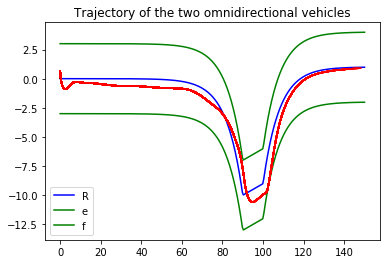

Intervention identified. Retrain agent in the pipeline.
1
262
[Epoch 1] avg_loss: 0.000
[Epoch 51] avg_loss: 0.000
Finished Training


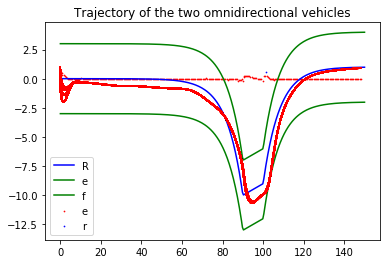

>>>>>Step 0 at [0.009178715132125759, 0.6459653324573957, 11.054699039462248, -1.1798340465846398]
Utilize NN output [[0.09298012 0.64754814]]
>>>>>Step 1 at [ 0.21985815  0.13483107 11.05933469 -0.86476569]
Utilize NN output [[0.07811695 0.5404594 ]]
>>>>>Step 2 at [ 0.57869639 -0.28601939 11.06323262 -0.59196749]
Utilize NN output [[0.09992853 0.44648564]]
>>>>>Step 3 at [ 1.0378378  -0.59475018 11.06821248 -0.36018949]
Utilize NN output [[0.11197089 0.35365373]]
>>>>>Step 4 at [ 1.55586653 -0.78984975 11.07378774 -0.17224468]
Utilize NN output [[0.11725586 0.2727287 ]]
>>>>>Step 5 at [ 2.10150646 -0.88477393 11.07962381 -0.02487356]
Utilize NN output [[0.11537829 0.19280213]]
>>>>>Step 6 at [ 2.65545983 -0.89855556 11.08536726  0.08063112]
Utilize NN output [[0.10947093 0.12080572]]
>>>>>Step 7 at [ 3.20806327 -0.85390171 11.09081905  0.14726607]
Utilize NN output [[0.10182799 0.05933139]]
>>>>>Step 8 at [ 3.7567273  -0.7725129  11.09589292  0.1801292 ]
Utilize NN output [[0.0933444

Utilize NN output [[ 0.16515805 -0.01405191]]
>>>>>Step 129 at [73.10553057 -1.95581688 11.98216988 -0.13599168]
Utilize NN output [[ 0.14165951 -0.00262156]]
>>>>>Step 130 at [73.699282   -2.03706361 11.98920586 -0.13756227]
Utilize NN output [[0.12183563 0.00439721]]
>>>>>Step 131 at [74.29322944 -2.11928768 11.99526767 -0.13492634]
Utilize NN output [[0.10492475 0.00784307]]
>>>>>Step 132 at [74.88767121 -2.19998382 12.00049474 -0.13022245]
Utilize NN output [[0.09037618 0.00854748]]
>>>>>Step 133 at [75.48272726 -2.27791448 12.00500129 -0.12509387]
Utilize NN output [[0.07787574 0.00726911]]
>>>>>Step 134 at [76.07838334 -2.35281853 12.00888722 -0.12073067]
Utilize NN output [[ 0.13287209 -0.03618427]]
>>>>>Step 135 at [76.67462092 -2.42515449 12.01549201 -0.14244783]
Utilize NN output [[ 0.11334725 -0.02489431]]
>>>>>Step 136 at [77.2694502  -2.51046443 12.02113522 -0.15740061]
Utilize NN output [[ 0.09715356 -0.01688907]]
>>>>>Step 137 at [77.86319631 -2.60469994 12.02597767 -0.1

Utilize NN output [[ 0.01817309 -0.0111308 ]]
>>>>>Step 256 at [1.45150328e+02 8.74470658e-01 1.23176389e+01 8.59893823e-03]
Utilize NN output [[ 0.0150959  -0.00270464]]
>>>>>Step 257 at [1.45766207e+02 8.79766686e-01 1.23183937e+01 6.93320110e-03]
Utilize NN output [[0.01256879 0.00319429]]
>>>>>Step 258 at [1.46382127e+02 8.84037056e-01 1.23190221e+01 8.90062134e-03]
Utilize NN output [[0.01048241 0.00692085]]
>>>>>Step 259 at [1.46998067e+02 8.89519448e-01 1.23195462e+01 1.31634604e-02]
Utilize NN output [[0.00875126 0.00888888]]
>>>>>Step 260 at [1.47614002e+02 8.97627750e-01 1.23199837e+01 1.86386616e-02]
Utilize NN output [[ 0.01536744 -0.00977768]]
>>>>>Step 261 at [1.48229913e+02 9.09108844e-01 1.23207521e+01 1.26158100e-02]
Utilize NN output [[ 0.01276701 -0.00238034]]
>>>>>Step 262 at [1.48845918e+02 9.16880652e-01 1.23213904e+01 1.11494358e-02]


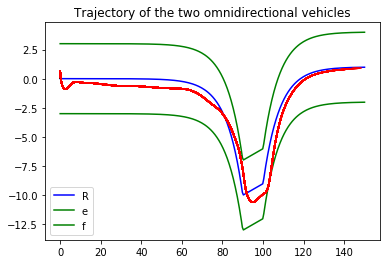

No intervention. Agent is clear.


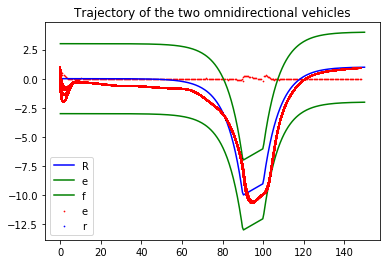

<<<<<<<<<<<<<<<<<<<<
Finished epoch 1




>>>>>>>>>>>>>>>>>>>>
Start epoch 2
Optimize rajectory 0
Finished iteration 0 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 40 [Unsafe]
Finished iteration 50 [Unsafe]
Finished iteration 60 [Unsafe]
Finished iteration 70 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 80 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 90 [Unsafe]


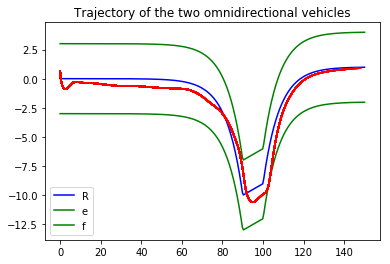

Optimize rajectory 1
Finished iteration 0 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 30 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 40 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 50 [Unsafe]
Finished iteration 60 [Unsafe]
Finished iteration 70 [Unsafe]
Finished iteration 80 [Unsafe]
Finished iteration 90 [Unsafe]


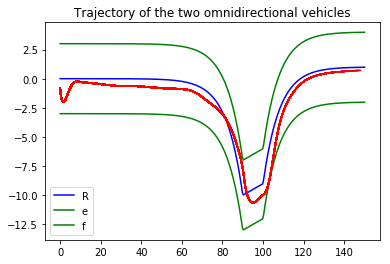

Optimize rajectory 2
Finished iteration 0 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 40 [Unsafe]
Finished iteration 50 [Unsafe]
Finished iteration 60 [Unsafe]
Finished iteration 70 [Unsafe]
Finished iteration 80 [Unsafe]
Finished iteration 90 [Unsafe]


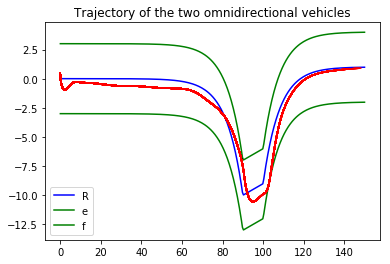

Optimize rajectory 3
Finished iteration 0 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 30 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 40 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 50 [Unsafe]
Finished iteration 60 [Unsafe]
Finished iteration 70 [Unsafe]
Finished iteration 80 [Unsafe]
Finished iteration 90 [Unsafe]


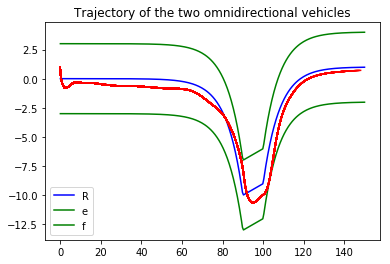

Optimize rajectory 4
Finished iteration 0 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 40 [Unsafe]
Finished iteration 50 [Unsafe]
Finished iteration 60 [Unsafe]
Finished iteration 70 [Unsafe]
Finished iteration 80 [Unsafe]
Finished iteration 90 [Unsafe]


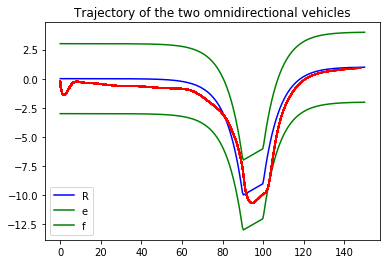

5
1310
[Epoch 1] avg_loss: 0.000
[Epoch 51] avg_loss: 0.000
Finished Training


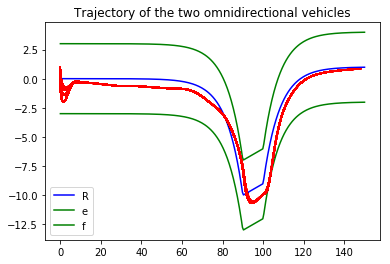

>>>>>Step 0 at [0.009178715132125759, 0.6459653324573957, 11.054699039462248, -1.1798340465846398]
Utilize NN output [[0.09295672 0.64827436]]
>>>>>Step 1 at [ 0.21985814  0.1348311  11.05933353 -0.86449481]
Utilize NN output [[0.07806718 0.5409618 ]]
>>>>>Step 2 at [ 0.57881028 -0.28592205 11.06322898 -0.5914865 ]
Utilize NN output [[0.09984743 0.44679   ]]
>>>>>Step 3 at [ 1.03809991 -0.59443181 11.06820483 -0.35956979]
Utilize NN output [[0.11181655 0.35375506]]
>>>>>Step 4 at [ 1.55624891 -0.78921012 11.07377247 -0.1715755 ]
Utilize NN output [[0.11708099 0.27274767]]
>>>>>Step 5 at [ 2.10195127 -0.88376898 11.07959992 -0.02419483]
Utilize NN output [[0.11519813 0.1927391 ]]
>>>>>Step 6 at [ 2.65591244 -0.89717459 11.08533448  0.08127597]
Utilize NN output [[0.10929672 0.12067784]]
>>>>>Step 7 at [ 3.20848512 -0.85216456 11.09077766  0.14784087]
Utilize NN output [[0.10163223 0.05919635]]
>>>>>Step 8 at [ 3.7571     -0.77046072 11.09584185  0.18062925]
Utilize NN output [[0.0931678

Utilize NN output [[0.09808643 0.01647948]]
>>>>>Step 128 at [72.51056627 -1.88971212 11.97397807 -0.13089614]
Utilize NN output [[ 0.16494432 -0.01411714]]
>>>>>Step 129 at [73.10434608 -1.96788256 11.9821513  -0.1393475 ]
Utilize NN output [[ 0.14152114 -0.00230134]]
>>>>>Step 130 at [73.69782043 -2.0511212  11.98918049 -0.14072624]
Utilize NN output [[0.12176973 0.00495656]]
>>>>>Step 131 at [74.2915034  -2.13522389 11.99523907 -0.13775502]
Utilize NN output [[0.10492083 0.0085279 ]]
>>>>>Step 132 at [74.88571311 -2.217601   12.00046594 -0.13264043]
Utilize NN output [[0.0904191  0.00926682]]
>>>>>Step 133 at [75.48057761 -2.29697009 12.00497462 -0.12708028]
Utilize NN output [[0.07793958 0.00796688]]
>>>>>Step 134 at [76.07608248 -2.37305704 12.00886372 -0.12229828]
Utilize NN output [[ 0.1330213  -0.03552992]]
>>>>>Step 135 at [76.67220495 -2.44632746 12.01547583 -0.143623  ]
Utilize NN output [[ 0.11350773 -0.02433369]]
>>>>>Step 136 at [77.26693296 -2.53233628 12.02112697 -0.158

Utilize NN output [[ 0.02108179 -0.01320507]]
>>>>>Step 234 at [1.31683386e+02 5.76105384e-01 1.23133898e+01 2.68043840e-02]
Utilize NN output [[ 0.01751967 -0.00526847]]
>>>>>Step 235 at [1.32298857e+02 5.92606636e-01 1.23142657e+01 2.35607761e-02]
Utilize NN output [[0.01458786 0.00042837]]
>>>>>Step 236 at [1.32914417e+02 6.07112406e-01 1.23149950e+01 2.38245299e-02]
Utilize NN output [[0.01216555 0.00416121]]
>>>>>Step 237 at [1.33530007e+02 6.21781329e-01 1.23156033e+01 2.63867772e-02]
Utilize NN output [[ 0.02128621 -0.01204415]]
>>>>>Step 238 at [1.34145600e+02 6.38028599e-01 1.23166674e+01 1.89705852e-02]
Utilize NN output [[ 0.01768581 -0.00389009]]
>>>>>Step 239 at [1.34761344e+02 6.49711037e-01 1.23175516e+01 1.65749531e-02]
Utilize NN output [[0.01472587 0.00187408]]
>>>>>Step 240 at [1.35377156e+02 6.59919017e-01 1.23182878e+01 1.77291554e-02]
Utilize NN output [[0.01228015 0.00556468]]
>>>>>Step 241 at [1.35992989e+02 6.70838359e-01 1.23189018e+01 2.11564893e-02]
Utilize 

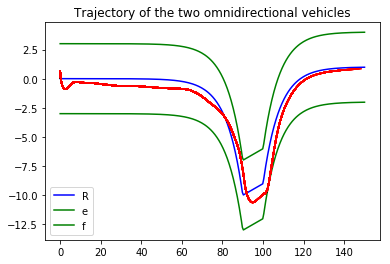

Intervention identified. Retrain agent in the pipeline.
1
262
[Epoch 1] avg_loss: 0.000
[Epoch 51] avg_loss: 0.000
Finished Training


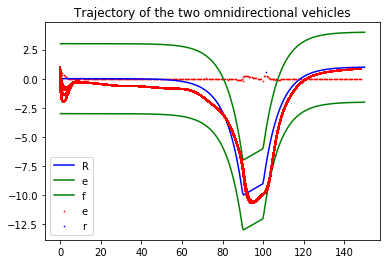

>>>>>Step 0 at [0.009178715132125759, 0.6459653324573957, 11.054699039462248, -1.1798340465846398]
Utilize NN output [[0.09178954 0.6483966 ]]
>>>>>Step 1 at [ 0.21985759  0.13483244 11.05927567 -0.86444924]
Utilize NN output [[0.07705937 0.54072905]]
>>>>>Step 2 at [ 0.57882622 -0.2859012  11.06312103 -0.5915397 ]
Utilize NN output [[0.09858228 0.44659346]]
>>>>>Step 3 at [ 1.03809365 -0.59443151 11.06803424 -0.35971487]
Utilize NN output [[0.11042995 0.3536128 ]]
>>>>>Step 4 at [ 1.5562048  -0.78928138 11.0735334  -0.17179311]
Utilize NN output [[0.11569855 0.27264768]]
>>>>>Step 5 at [ 2.10187311 -0.88395665 11.07929265 -0.02446707]
Utilize NN output [[0.11389048 0.19268449]]
>>>>>Step 6 at [ 2.65581365 -0.89751266 11.08496268  0.08097165]
Utilize NN output [[0.10809414 0.12066206]]
>>>>>Step 7 at [ 3.20837999 -0.85267241 11.09034644  0.1475257 ]
Utilize NN output [[0.10039788 0.05960814]]
>>>>>Step 8 at [ 3.75699775 -0.77114488 11.09534953  0.18054035]
Utilize NN output [[0.0920736

Utilize NN output [[0.10221505 0.01570025]]
>>>>>Step 128 at [72.50541395 -1.88113444 11.97970867 -0.13304965]
Utilize NN output [[ 0.17135239 -0.01437159]]
>>>>>Step 129 at [73.09931576 -1.96062246 11.98819341 -0.14165743]
Utilize NN output [[ 0.14710069 -0.00217359]]
>>>>>Step 130 at [73.69290209 -2.04527537 11.99549585 -0.1429603 ]
Utilize NN output [[0.12664835 0.00533153]]
>>>>>Step 131 at [74.28671418 -2.13075002 12.00179463 -0.13976261]
Utilize NN output [[0.1091888  0.00904125]]
>>>>>Step 132 at [74.88108711 -2.21436628 12.00723248 -0.1343372 ]
Utilize NN output [[0.09414972 0.00983684]]
>>>>>Step 133 at [75.47615595 -2.29479054 12.0119261  -0.12843172]
Utilize NN output [[0.08116977 0.00852708]]
>>>>>Step 134 at [76.07190614 -2.37172724 12.0159757  -0.12331052]
Utilize NN output [[ 0.13823937 -0.03500395]]
>>>>>Step 135 at [76.6683134  -2.44564556 12.02284397 -0.14433226]
Utilize NN output [[ 0.11802161 -0.02386158]]
>>>>>Step 136 at [77.26335034 -2.53212997 12.02871781 -0.158

Utilize NN output [[0.01334658 0.00317746]]
>>>>>Step 257 at [1.45883358e+02 8.24146133e-01 1.23408561e+01 8.95490236e-03]
Utilize NN output [[0.01111812 0.00689395]]
>>>>>Step 258 at [1.46500390e+02 8.29671742e-01 1.23414119e+01 1.32086972e-02]
Utilize NN output [[ 0.01945565 -0.01038722]]
>>>>>Step 259 at [1.47117431e+02 8.37822524e-01 1.23423846e+01 6.79928058e-03]
Utilize NN output [[ 0.01614315 -0.00204091]]
>>>>>Step 260 at [1.47734556e+02 8.42018596e-01 1.23431917e+01 5.53979605e-03]
Utilize NN output [[0.01342496 0.0037524 ]]
>>>>>Step 261 at [1.48351723e+02 8.45437610e-01 1.23438629e+01 7.85561490e-03]
Utilize NN output [[0.0111829  0.00736397]]
>>>>>Step 262 at [1.48968911e+02 8.50286101e-01 1.23444220e+01 1.24005236e-02]


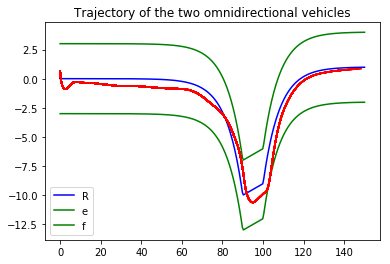

No intervention. Agent is clear.


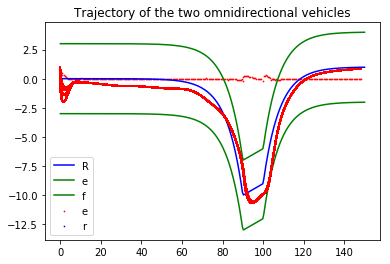

<<<<<<<<<<<<<<<<<<<<
Finished epoch 2




>>>>>>>>>>>>>>>>>>>>
Start epoch 3
Optimize rajectory 0
Finished iteration 0 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 40 [Unsafe]
Finished iteration 50 [Unsafe]
Finished iteration 60 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 70 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 80 [Unsafe]
Finished iteration 90 [Unsafe]


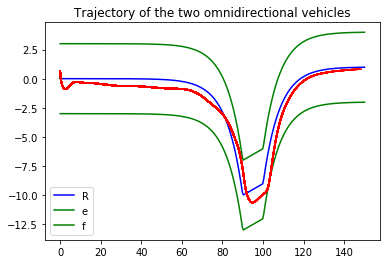

Optimize rajectory 1
Finished iteration 0 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 30 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 40 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 50 [Unsafe]
Finished iteration 60 [Unsafe]
Finished iteration 70 [Unsafe]
Finished iteration 80 [Unsafe]
Finished iteration 90 [Unsafe]


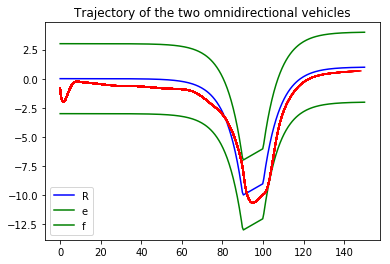

Optimize rajectory 2
Finished iteration 0 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 40 [Unsafe]
Finished iteration 50 [Unsafe]
Finished iteration 60 [Unsafe]
Finished iteration 70 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 80 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 90 [Unsafe]


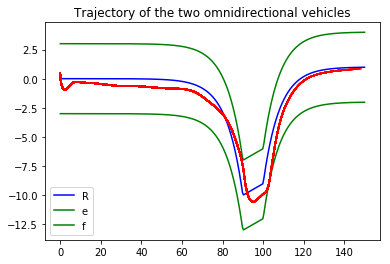

Optimize rajectory 3
Finished iteration 0 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 30 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 40 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 50 [Unsafe]
Finished iteration 60 [Unsafe]
Finished iteration 70 [Unsafe]
Finished iteration 80 [Unsafe]
Finished iteration 90 [Unsafe]


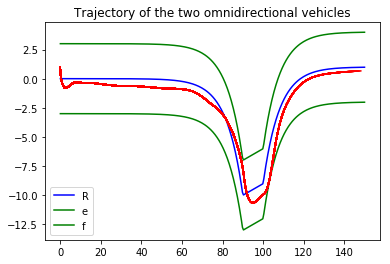

Optimize rajectory 4
Finished iteration 0 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 40 [Unsafe]
Finished iteration 50 [Unsafe]
Finished iteration 60 [Unsafe]
Finished iteration 70 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 80 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 90 [Unsafe]


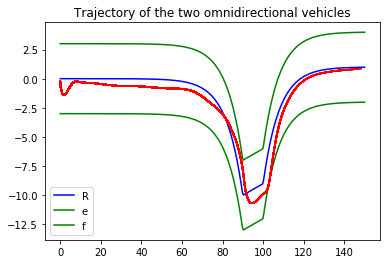

5
1310
[Epoch 1] avg_loss: 0.000
[Epoch 51] avg_loss: 0.000
Finished Training


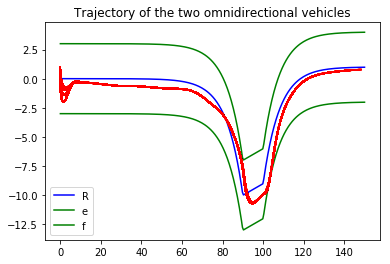

>>>>>Step 0 at [0.009178715132125759, 0.6459653324573957, 11.054699039462248, -1.1798340465846398]
Utilize NN output [[0.09170718 0.6491358 ]]
>>>>>Step 1 at [ 0.21985755  0.13483253 11.05927159 -0.86417379]
Utilize NN output [[0.07695388 0.54119295]]
>>>>>Step 2 at [ 0.57894184 -0.28580196 11.0631117  -0.59107036]
Utilize NN output [[0.09842721 0.4468513 ]]
>>>>>Step 3 at [ 1.03835348 -0.59411631 11.06801723 -0.35912816]
Utilize NN output [[0.11017903 0.35362834]]
>>>>>Step 4 at [ 1.55657777 -0.78866176 11.073504   -0.17119909]
Utilize NN output [[0.11542422 0.2725978 ]]
>>>>>Step 5 at [ 2.10230044 -0.88301257 11.07924972 -0.0238991 ]
Utilize NN output [[0.11361466 0.19257209]]
>>>>>Step 6 at [ 2.65624611 -0.89625389 11.08490613  0.0814792 ]
Utilize NN output [[0.10783131 0.12050573]]
>>>>>Step 7 at [ 3.20878648 -0.85113345 11.0902769   0.1479475 ]
Utilize NN output [[0.10010935 0.05948478]]
>>>>>Step 8 at [ 3.75736601 -0.76937509 11.09526571  0.18089379]
Utilize NN output [[0.0918132

Utilize NN output [[ 0.19638543 -0.01222096]]
>>>>>Step 115 at [64.79612806 -1.05131258 11.88329209 -0.07141862]
Utilize NN output [[ 0.1723061 -0.0070433]]
>>>>>Step 116 at [65.38899073 -1.09372615 11.89182313 -0.07560343]
Utilize NN output [[ 0.1503156  -0.00387207]]
>>>>>Step 117 at [65.98206935 -1.13865056 11.89928281 -0.07790572]
Utilize NN output [[ 0.12912242 -0.00242575]]
>>>>>Step 118 at [66.57538892 -1.18496728 11.90570329 -0.07934895]
Utilize NN output [[ 0.20984606 -0.02785545]]
>>>>>Step 119 at [67.16905875 -1.23217348 11.91604425 -0.0959266 ]
Utilize NN output [[ 0.17954576 -0.01691316]]
>>>>>Step 120 at [67.76234283 -1.28926041 11.9249263  -0.10600254]
Utilize NN output [[ 0.15388614 -0.00941832]]
>>>>>Step 121 at [68.35543219 -1.35236593 11.93256044 -0.11161801]
Utilize NN output [[ 0.1320647  -0.00467231]]
>>>>>Step 122 at [68.94851061 -1.41884045 11.93912555 -0.11440562]
Utilize NN output [[ 0.11342269 -0.00203513]]
>>>>>Step 123 at [69.54170472 -1.48700283 11.9447724

Utilize NN output [[ 0.02686967 -0.01967065]]
>>>>>Step 220 at [1.23160474e+02 1.00870173e-01 1.23207621e+01 7.49746737e-02]
Utilize NN output [[ 0.02235059 -0.0125086 ]]
>>>>>Step 221 at [1.23774809e+02 1.47016262e-01 1.23218794e+01 6.72693036e-02]
Utilize NN output [[ 0.01861285 -0.00701221]]
>>>>>Step 222 at [1.24389533e+02 1.88430788e-01 1.23228099e+01 6.29491911e-02]
Utilize NN output [[ 0.01551616 -0.00306035]]
>>>>>Step 223 at [1.25004472e+02 2.27191944e-01 1.23235857e+01 6.10635891e-02]
Utilize NN output [[ 0.02706548 -0.01628013]]
>>>>>Step 224 at [1.25619537e+02 2.64796748e-01 1.23249386e+01 5.10329967e-02]
Utilize NN output [[ 0.02249259 -0.00861256]]
>>>>>Step 225 at [1.26235009e+02 2.96233460e-01 1.23260631e+01 4.57256636e-02]
Utilize NN output [[ 0.01872255 -0.00297423]]
>>>>>Step 226 at [1.26850692e+02 3.24405582e-01 1.23269991e+01 4.38926444e-02]
Utilize NN output [[0.01560528 0.00086103]]
>>>>>Step 227 at [1.27466468e+02 3.51450981e-01 1.23277793e+01 4.44233377e-02]
Ut

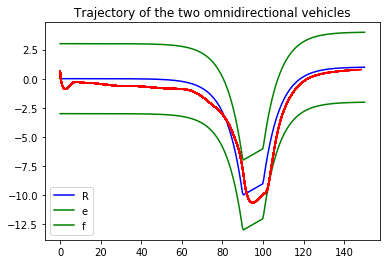

Intervention identified. Retrain agent in the pipeline.
1
262
[Epoch 1] avg_loss: 0.000
[Epoch 51] avg_loss: 0.000
Finished Training


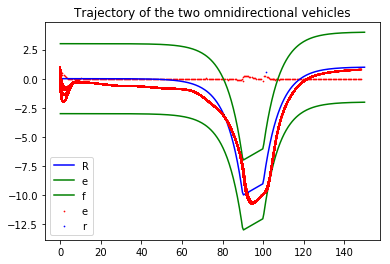

>>>>>Step 0 at [0.009178715132125759, 0.6459653324573957, 11.054699039462248, -1.1798340465846398]
Utilize NN output [[0.09060538 0.649289  ]]
>>>>>Step 1 at [ 0.21985703  0.1348338  11.05921695 -0.86411674]
Utilize NN output [[0.07600402 0.54101026]]
>>>>>Step 2 at [ 0.57896277 -0.28577724 11.06300985 -0.59109104]
Utilize NN output [[0.09723202 0.44669762]]
>>>>>Step 3 at [ 1.03836258 -0.59409742 11.06785619 -0.35922105]
Utilize NN output [[0.10887218 0.35352337]]
>>>>>Step 4 at [ 1.55655975 -0.78868761 11.07327839 -0.1713461 ]
Utilize NN output [[0.11411928 0.27251774]]
>>>>>Step 5 at [ 2.10225585 -0.88311645 11.07895972 -0.0240903 ]
Utilize NN output [[0.11237757 0.19251905]]
>>>>>Step 6 at [ 2.65618294 -0.89646331 11.08455506  0.08125693]
Utilize NN output [[0.10669152 0.12047949]]
>>>>>Step 7 at [ 3.20871443 -0.85146722 11.08986949  0.1477088 ]
Utilize NN output [[0.09903971 0.05927579]]
>>>>>Step 8 at [ 3.75729201 -0.769843   11.09480534  0.1805384 ]
Utilize NN output [[0.0907580

Utilize NN output [[0.10603201 0.01406616]]
>>>>>Step 128 at [72.49907259 -1.88893265 11.98548281 -0.1385117 ]
Utilize NN output [[0.09176618 0.01837777]]
>>>>>Step 129 at [73.09272053 -1.97168975 11.99005829 -0.12749961]
Utilize NN output [[ 0.1553712  -0.01495724]]
>>>>>Step 130 at [73.68754833 -2.04794372 11.99776493 -0.13646585]
Utilize NN output [[ 0.13322356 -0.0041824 ]]
>>>>>Step 131 at [74.28202342 -2.12957664 12.00438698 -0.13897481]
Utilize NN output [[0.11455487 0.0024366 ]]
>>>>>Step 132 at [74.87659697 -2.21274351 12.0100898  -0.13751232]
Utilize NN output [[0.09864474 0.00568637]]
>>>>>Step 133 at [75.47155449 -2.29507712 12.0150061  -0.13409766]
Utilize NN output [[0.08499648 0.00634045]]
>>>>>Step 134 at [76.06701652 -2.37540928 12.01924572 -0.13028869]
Utilize NN output [[ 0.1443649  -0.03567311]]
>>>>>Step 135 at [76.663063   -2.45350982 12.02641423 -0.15171779]
Utilize NN output [[ 0.12338035 -0.0234551 ]]
>>>>>Step 136 at [77.25762797 -2.54441447 12.03255214 -0.165

Utilize NN output [[0.01231161 0.00719931]]
>>>>>Step 257 at [1.45979379e+02 7.49149132e-01 1.23584911e+01 1.30516979e-02]
Utilize NN output [[0.0102599  0.00904902]]
>>>>>Step 258 at [1.46597264e+02 7.57214035e-01 1.23590041e+01 1.86431568e-02]
Utilize NN output [[ 0.01797142 -0.00966832]]
>>>>>Step 259 at [1.47215129e+02 7.68734329e-01 1.23599025e+01 1.26688041e-02]
Utilize NN output [[ 0.01490335 -0.00234386]]
>>>>>Step 260 at [1.47833093e+02 7.76563615e-01 1.23606476e+01 1.12203133e-02]
Utilize NN output [[0.01238335 0.0027804 ]]
>>>>>Step 261 at [1.48451102e+02 7.83498160e-01 1.23612668e+01 1.29386863e-02]
Utilize NN output [[0.01030456 0.00601299]]
>>>>>Step 262 at [1.49069127e+02 7.91495031e-01 1.23617820e+01 1.66550520e-02]


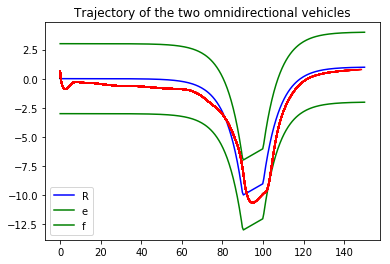

No intervention. Agent is clear.


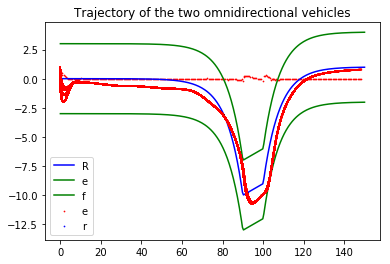

<<<<<<<<<<<<<<<<<<<<
Finished epoch 3




>>>>>>>>>>>>>>>>>>>>
Start epoch 4
Optimize rajectory 0
Finished iteration 0 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 40 [Unsafe]
Finished iteration 50 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 60 [Unsafe]
Finished iteration 70 [Unsafe]
Finished iteration 80 [Unsafe]
Finished iteration 90 [Unsafe]


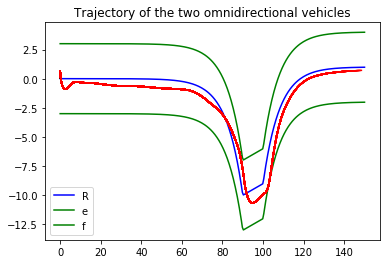

Optimize rajectory 1
Finished iteration 0 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 30 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 40 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 50 [Unsafe]
Finished iteration 60 [Unsafe]
Finished iteration 70 [Unsafe]
Finished iteration 80 [Unsafe]
Finished iteration 90 [Unsafe]


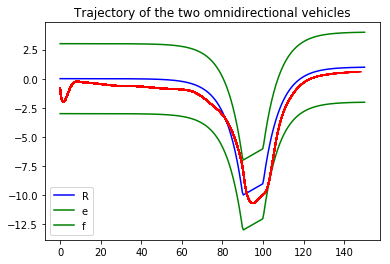

Optimize rajectory 2
Finished iteration 0 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 40 [Unsafe]
Finished iteration 50 [Unsafe]
Finished iteration 60 [Unsafe]
Finished iteration 70 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 80 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 90 [Unsafe]
Found new optimal solution. Load QP parameters.


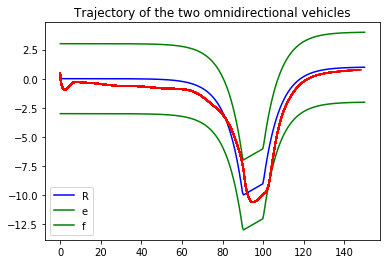

Optimize rajectory 3
Finished iteration 0 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 30 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 40 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 50 [Unsafe]
Finished iteration 60 [Unsafe]
Finished iteration 70 [Unsafe]
Finished iteration 80 [Unsafe]
Finished iteration 90 [Unsafe]


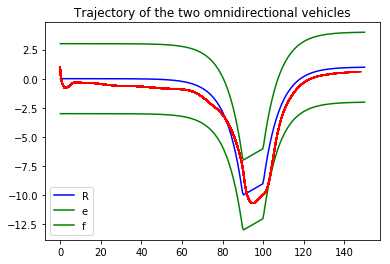

Optimize rajectory 4
Finished iteration 0 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 40 [Unsafe]
Finished iteration 50 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 60 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 70 [Unsafe]
Finished iteration 80 [Unsafe]
Finished iteration 90 [Unsafe]


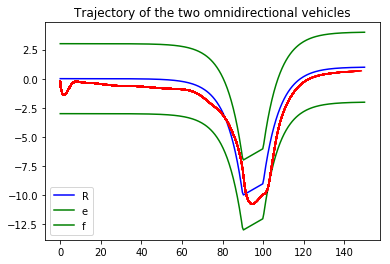

5
1310
[Epoch 1] avg_loss: 0.000
[Epoch 51] avg_loss: 0.000
Finished Training


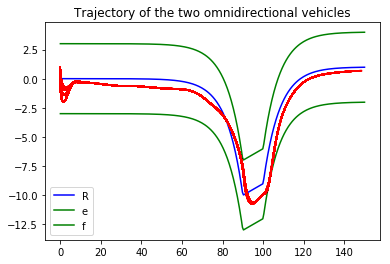

>>>>>Step 0 at [0.009178715132125759, 0.6459653324573957, 11.054699039462248, -1.1798340465846398]
Utilize NN output [[0.09047112 0.65031767]]
>>>>>Step 1 at [ 0.21985697  0.13483395 11.05921029 -0.86373389]
Utilize NN output [[0.07584035 0.54163146]]
>>>>>Step 2 at [ 0.57912337 -0.28563916 11.06299506 -0.59044868]
Utilize NN output [[0.09699742 0.4470338 ]]
>>>>>Step 3 at [ 1.03872027 -0.59366361 11.06782978 -0.35842574]
Utilize NN output [[0.10848931 0.35347703]]
>>>>>Step 4 at [ 1.55707036 -0.78784098 11.07323306 -0.17057393]
Utilize NN output [[0.11370618 0.2723978 ]]
>>>>>Step 5 at [ 2.10283647 -0.88184796 11.07889399 -0.02338046]
Utilize NN output [[0.11196585 0.19233549]]
>>>>>Step 6 at [ 2.65676911 -0.89480151 11.08446901  0.08186814]
Utilize NN output [[0.10630174 0.12025634]]
>>>>>Step 7 at [ 3.20926822 -0.84946811 11.08976416  0.14819759]
Utilize NN output [[0.09866084 0.05884057]]
>>>>>Step 8 at [ 3.75780016 -0.76757661 11.09468126  0.18078639]
Utilize NN output [[0.0903687

Utilize NN output [[0.10579279 0.0118423 ]]
>>>>>Step 128 at [72.497793   -1.90893085 11.98555236 -0.14276675]
Utilize NN output [[0.09154171 0.01730273]]
>>>>>Step 129 at [73.09108659 -1.99421366 11.9901167  -0.13239864]
Utilize NN output [[ 0.15505593 -0.01516776]]
>>>>>Step 130 at [73.6855362  -2.07338111 11.99780796 -0.14149111]
Utilize NN output [[ 0.13301484 -0.00378883]]
>>>>>Step 131 at [74.27959543 -2.15800065 12.00441975 -0.14376398]
Utilize NN output [[0.11445259 0.0032148 ]]
>>>>>Step 132 at [74.87376536 -2.24401428 12.01011753 -0.1418344 ]
Utilize NN output [[0.09863324 0.0066694 ]]
>>>>>Step 133 at [75.46836283 -2.32891876 12.01503326 -0.13782944]
Utilize NN output [[0.08504543 0.00739434]]
>>>>>Step 134 at [76.06352234 -2.41147268 12.01927531 -0.13338736]
Utilize NN output [[ 0.14453338 -0.03463345]]
>>>>>Step 135 at [76.65932562 -2.49142002 12.02645207 -0.15419249]
Utilize NN output [[ 0.1235953  -0.02250371]]
>>>>>Step 136 at [77.25366595 -2.58379609 12.03260056 -0.167

Utilize NN output [[ 0.02104751 -0.00491111]]
>>>>>Step 233 at [1.31249401e+02 4.12915079e-01 1.23513734e+01 2.34339154e-02]
Utilize NN output [[0.01749717 0.00077734]]
>>>>>Step 234 at [1.31866822e+02 4.27386319e-01 1.23522481e+01 2.39139769e-02]
Utilize NN output [[0.01456763 0.00445873]]
>>>>>Step 235 at [1.32484276e+02 4.42154915e-01 1.23529765e+01 2.66677277e-02]
Utilize NN output [[0.01214055 0.00650228]]
>>>>>Step 236 at [1.33101721e+02 4.58624658e-01 1.23535835e+01 3.06837941e-02]
Utilize NN output [[ 0.02123491 -0.01095951]]
>>>>>Step 237 at [1.33719135e+02 4.77575239e-01 1.23546450e+01 2.39146059e-02]
Utilize NN output [[ 0.01761794 -0.0038147 ]]
>>>>>Step 238 at [1.34336713e+02 4.92347181e-01 1.23555258e+01 2.15581533e-02]
Utilize NN output [[0.01464372 0.00124732]]
>>>>>Step 239 at [1.34954364e+02 5.05664660e-01 1.23562580e+01 2.23287197e-02]
Utilize NN output [[0.01218816 0.00450385]]
>>>>>Step 240 at [1.35572038e+02 5.19458825e-01 1.23568674e+01 2.51112395e-02]
Utilize NN

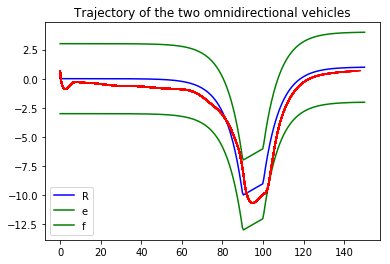

Intervention identified. Retrain agent in the pipeline.
1
261
[Epoch 1] avg_loss: 0.000
[Epoch 51] avg_loss: 0.000
Finished Training


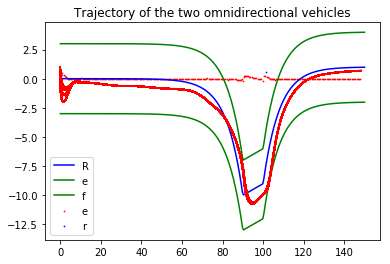

>>>>>Step 0 at [0.009178715132125759, 0.6459653324573957, 11.054699039462248, -1.1798340465846398]
Utilize NN output [[0.08941057 0.6505331 ]]
>>>>>Step 1 at [ 0.21985647  0.13483517 11.05915769 -0.86365378]
Utilize NN output [[0.0749281  0.54153067]]
>>>>>Step 2 at [ 0.5791541  -0.2856063  11.0628971  -0.59041199]
Utilize NN output [[0.09584701 0.44694504]]
>>>>>Step 3 at [ 1.03875706 -0.59361037 11.06767483 -0.35843156]
Utilize NN output [[0.10723867 0.3534386 ]]
>>>>>Step 4 at [ 1.55709732 -0.7877875  11.0730163  -0.17060121]
Utilize NN output [[0.11245407 0.2723526 ]]
>>>>>Step 5 at [ 2.10284866 -0.88180725 11.07861543 -0.02343385]
Utilize NN output [[0.11077531 0.19228739]]
>>>>>Step 6 at [ 2.65676521 -0.89479002 11.08413165  0.08178641]
Utilize NN output [[0.10520267 0.12021016]]
>>>>>Step 7 at [ 3.20924986 -0.84950327 11.08937246  0.14808861]
Utilize NN output [[0.09763777 0.05855604]]
>>>>>Step 8 at [ 3.7577701  -0.76767462 11.09423889  0.18051904]
Utilize NN output [[0.0893489

Utilize NN output [[ 0.16014282 -0.01545766]]
>>>>>Step 130 at [73.6862374  -2.06463388 12.00294844 -0.1438964 ]
Utilize NN output [[ 0.13745315 -0.00367611]]
>>>>>Step 131 at [74.28035114 -2.1507197  12.00977814 -0.1461026 ]
Utilize NN output [[0.11834788 0.00358734]]
>>>>>Step 132 at [74.87458811 -2.23816234 12.01566806 -0.14394845]
Utilize NN output [[0.10205609 0.00719135]]
>>>>>Step 133 at [75.4692836  -2.32436405 12.02075322 -0.13962808]
Utilize NN output [[0.08803701 0.00797856]]
>>>>>Step 134 at [76.06458056 -2.40802864 12.02514373 -0.13483276]
Utilize NN output [[ 0.14931571 -0.03404804]]
>>>>>Step 135 at [76.66056422 -2.4888773  12.03255452 -0.15529648]
Utilize NN output [[ 0.12776741 -0.02194446]]
>>>>>Step 136 at [77.25510872 -2.58195744 12.03890836 -0.16849676]
Utilize NN output [[ 0.10986329 -0.01360107]]
>>>>>Step 137 at [77.84866421 -2.68292698 12.04437953 -0.17668336]
Utilize NN output [[ 0.09481533 -0.00852833]]
>>>>>Step 138 at [78.4416242  -2.78879709 12.04910614 -0

Utilize NN output [[0.01184262 0.00701201]]
>>>>>Step 262 at [1.49028276e+02 6.93469289e-01 1.23750750e+01 1.15581166e-02]


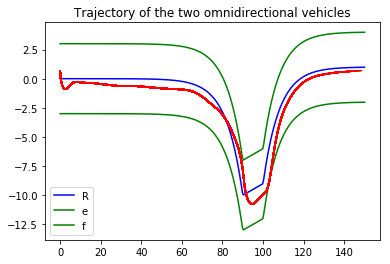

No intervention. Agent is clear.


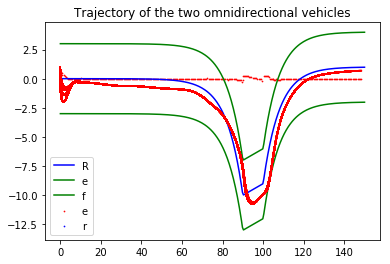

<<<<<<<<<<<<<<<<<<<<
Finished epoch 4






In [190]:
def QP(P_qp, q_qp, G_qp, h_qp, A_qp = None, b_qp = None):
    P_qp = numpy_sparse_to_spmatrix(P_qp)
    q_qp = matrix(q_qp)
    G_qp = numpy_sparse_to_spmatrix(G_qp)
    h_qp = matrix(h_qp)
    print("Starting solving QP")
    solvers.options['feastol'] = 1e-5
    sol=solvers.qp(P_qp, q_qp, G_qp, h_qp, A_qp, b_qp)
    #sol = {'x': [0.0 for i in range(dynamics.state_size * (N - n + 1) + agent.num_parameters(agent.model))]}
    theta_diffs = list(sol['x'])
    if theta_diffs is None:
        theta_diffs = np.zeros(agent.num_parameters(agent.model))
    return theta_diffs


#x0s = x0s[:1]

#  # loop over the dataset multiple times 
agent_0 = NeuralNetwork(input_size = (n + 1) * dynamics.state_size, \
                      model_name = 'mlp_H2_MPSC_0', \
                      batch_size = 1000, \
                      checkpoint = checkpoint_0)

agent_traj_0 = agent_run(agent_0, x0s)
draw_agent_traj(agent_traj_0)

agent = NeuralNetwork(input_size = (n + 1) * dynamics.state_size, \
                      model_name = 'mlp_H2_MPSC_1', \
                      batch_size = 1000, \
                      checkpoint = 'checkpoints/mlp_temp_H2_temp.pt')
agent_traj = agent_run(agent, x0s)
draw_agent_traj(agent_traj)

data_trajs = agent_traj

num_epoch = 5
tol = 1e-5

for epoch in range(num_epoch):
    print(">>>>>>>>>>>>>>>>>>>>")
    print("Start epoch {}".format(epoch))
    # Initialize Q matrix 
    Q1 = []
    Qx = []
    Qu = []
    Qx_T = []
    Qu_T = []
    Qxx = []
    Quu = []
    Qux = []
    Qxu = []

    # Initialize K, k
    K = []
    k = []

    # Run the latest model and original model to get (pi_\theta - u^*)
    u_diffs = []
    # Run the latest model to get gradient on the input x   
    pix = []
    # Run the latest model to get gradient on \theta
    pitheta = []

    # Barrier 1st order and 2nd order
    b1 = []
    bx = []
    bx_T = []
    bxx = []

    xs_diff = []
    us_diff = []
        
    h_qp = []
    G_qp = []
    
    theta_diffs = np.zeros([len(data_trajs), agent.num_parameters(agent.model)])
    P_qp = np.eye(agent.num_parameters(agent.model))
    q_qp = np.zeros([agent.num_parameters(agent.model), 1])
    
    num_itr = 10
    
    for i_traj in range(len(data_trajs)):
        print("Optimize rajectory {}".format(i_traj))
        Q1.append(np.empty([len(data_trajs[i_traj]), 1, 1]))
        Qx.append(np.empty([len(data_trajs[i_traj]), dynamics.state_size, 1])) 
        Qu.append(np.empty([len(data_trajs[i_traj]), dynamics.action_size, 1]))
        Qx_T.append(np.empty([len(data_trajs[i_traj]), 1, dynamics.state_size])) 
        Qu_T.append(np.empty([len(data_trajs[i_traj]), 1, dynamics.action_size]))
        Qxx.append(np.empty([len(data_trajs[i_traj]), dynamics.state_size, dynamics.state_size]))
        Quu.append(np.empty([len(data_trajs[i_traj]), dynamics.action_size, dynamics.action_size]))
        Qux.append(np.empty([len(data_trajs[i_traj]), dynamics.action_size, dynamics.state_size]))
        Qxu.append(np.empty([len(data_trajs[i_traj]), dynamics.state_size, dynamics.action_size]))

        # Initialize K, k
        K.append(np.empty([len(data_trajs[i_traj]), dynamics.action_size, dynamics.state_size]))
        k.append(np.empty([len(data_trajs[i_traj]), dynamics.action_size, 1]))

        # Run the latest model and original model to get (pi_\theta - u^*)
        u_diffs.append(np.empty([len(data_trajs[i_traj]), dynamics.action_size, 1]))
        # Run the latest model to get gradient on the input x   
        pix.append(np.empty([len(data_trajs[i_traj]), dynamics.state_size, dynamics.action_size]))
        # Run the latest model to get gradient on \theta
        pitheta.append(np.empty([len(data_trajs[i_traj]), \
                                 agent.num_parameters(agent.model), dynamics.action_size]))

        # Barrier 1st order and 2nd order
        b1.append(np.empty([len(data_trajs[i_traj]), 1]))
        bx.append(np.empty([len(data_trajs[i_traj]), dynamics.state_size, 1]))
        bx_T.append(np.empty([len(data_trajs[i_traj]), 1, dynamics.state_size]))
        bxx.append(np.empty([len(data_trajs[i_traj]), dynamics.state_size, dynamics.state_size]))

        xs_diff.append(np.empty([len(data_trajs[i_traj]), dynamics.state_size, 1]))
        us_diff.append(np.empty([len(data_trajs[i_traj]), dynamics.action_size, 1]))

        h_qp.append(np.zeros([len(data_trajs[i_traj]) * dynamics.action_size, 1]))
        G_qp.append(np.zeros([len(data_trajs[i_traj]) * dynamics.action_size , \
                              agent.num_parameters(agent.model)]))
        
        data_traj_opt = data_trajs[i_traj][:]
        J_opt = float('inf')
        converged = False
        
        alphas = 0.9**(np.arange(num_itr)**2)
        mus = 1.1**(np.arange(num_itr)**2)
        
        for i_itr in range(num_itr**2):
            alpha = alphas[int(i_itr/num_itr)]
            mu = mus[int(i_itr%num_itr)] 
            
            data_traj = data_trajs[i_traj][:]
            x_new = np.reshape([i for i in data_traj[0][0][:4]], [dynamics.state_size, 1])
            
            data_traj_tmp = []
            xs = []
            us = []
            
            agent.optimizer.zero_grad()
            J_new = 0.0
            
            for i_xy in range(len(data_traj)):
                x_y = data_traj[i_xy]
                x = np.reshape([i for i in x_y[0][:dynamics.state_size]], [dynamics.state_size, 1])
                u = np.reshape([i for i in x_y[1][:]], [dynamics.action_size, 1])

                x_u = x - np.reshape(barrier_u(x_y[0][:dynamics.state_size]), x.shape)
                x_l = x - np.reshape(barrier_l(x_y[0][:dynamics.state_size]), x.shape)

                b1[i_traj][i_xy] = q1[0] * np.exp(q2[0] * (A[0].dot(x_u) - b[0])) - q1[0]\
                        + q1[1] * np.exp(q2[1] * (A[1].dot(x_l) - b[1])) - q1[1]
                bx[i_traj][i_xy] = q1[0] * q2[0]\
                    * np.exp(q2[0] * (A[0].dot(x_u) - b[0])) * A[0].T + q1[1] * q2[1]\
                    * np.exp(q2[1] * (A[1].dot(x_l) - b[1])) * A[1].T
                
                bx_T[i_traj][i_xy] = bx[i_traj][i_xy].T

                bxx[i_traj][i_xy] = q1[0] * q2[0]**2\
                    * np.exp(q2[0] * (A[0].dot(x_u) - b[0])) * A[0].T * A[0]\
                    + q1[1] * q2[1]**2\
                    * np.exp(q2[1] * (A[1].dot(x_l) - b[1])) * A[1].T * A[1]

                i = abs(int(x[0]/0.5))
                x_nn = []
                for j in [x[:, 0]] + x_nominal[i : i + H]:
                    for e in j:
                        x_nn.append(e)
                while len(x_nn) < 4 *(H + 1):
                    for e in x_nominal[-1]:
                        x_nn.append(e)

                x_nn = np.asarray(x_nn)
                x_input = torch.tensor([x_nn], requires_grad = True).float().to(agent.device)   
                u_output = agent.model(x_input)[0]
                
                for i in range(dynamics.action_size):
                    # Get gradient w.r.t input x[0:4] <<<< pix 
                    pix[i_traj][i_xy, :, i] = torch.autograd.grad(\
                    u_output[i], x_input, retain_graph = True)[0].cpu().numpy().T[0:dynamics.state_size, 0]

                    # Get gradient w.r.t model parameters theta <<<< g_theta
                    torch.autograd.backward(u_output[i], retain_graph = True)
                    j = 0
                    for theta in agent.model.parameters():
                        pitheta_ = theta.grad.data.flatten()
                        pitheta[i_traj][i_xy, j : j + pitheta_.size()[0], i] = pitheta_.cpu().numpy()
                        j += pitheta_.size()[0]    

                u_output = u_output.detach().cpu().numpy()
                u_output = np.reshape(u_output, [dynamics.action_size, 1])

                u_0 = agent_0.run([x_nn])[0]
                u_0 = np.reshape(u_0, [dynamics.action_size, 1])

                u_diffs[i_traj][i_xy] = u_output - u_0

                Q1[i_traj][i_xy] = 4 * b1[i_traj][i_xy]
                Qx[i_traj][i_xy] = -2 * pix[i_traj][i_xy].dot(u_diffs[i_traj][i_xy]) + \
                                    2 * bx[i_traj][i_xy]
                Qx_T[i_traj][i_xy] = 2 * u_diffs[i_traj][i_xy].T.dot(pix[i_traj][i_xy].T) + \
                                    2 * bx[i_traj][i_xy].T
                Qu[i_traj][i_xy] = 2 * u_diffs[i_traj][i_xy]
                Qu_T[i_traj][i_xy] = 2 * u_diffs[i_traj][i_xy].T

                Qxx[i_traj][i_xy] = (pix[i_traj][i_xy].dot(u_diffs[i_traj][i_xy])).dot(\
                                    u_diffs[i_traj][i_xy].T.dot(pix[i_traj][i_xy].T)) + 2 * bxx[i_traj][i_xy]
                Quu[i_traj][i_xy] = u_diffs[i_traj][i_xy].dot(u_diffs[i_traj][i_xy].T) + \
                            mu * np.eye(Quu[i_traj][i_xy].shape[0])
                Qux[i_traj][i_xy] = u_diffs[i_traj][i_xy].dot(u_diffs[i_traj][i_xy].T.dot(pix[i_traj][i_xy].T))
                Qxu[i_traj][i_xy] = (pix[i_traj][i_xy].dot(u_diffs[i_traj][i_xy])).dot(u_diffs[i_traj][i_xy].T)

                K[i_traj][i_xy] = - np.linalg.solve(Quu[i_traj][i_xy], Qux[i_traj][i_xy])
                k[i_traj][i_xy] = - np.linalg.solve(Quu[i_traj][i_xy], Qu[i_traj][i_xy])

                x_diff = x_new - x

                us_diff[i_traj][i_xy] = alpha * k[i_traj][i_xy] + K[i_traj][i_xy].dot(x_diff)
                xs_diff[i_traj][i_xy] = x_diff
                
                u_new = u_output + us_diff[i_traj][i_xy]
                u_new = u_new.flatten().tolist()
                x_new = x_new.flatten().tolist()
                
                data_traj_tmp.append([x_new, u_new])
                xs.append(x_new)
                us.append(u_new)

                if i_xy < len(data_traj) - 1:
                    x_new = dynamics.f(xs[-1], us[-1], i_xy)[0]
                    x_new = np.reshape(x_new, x.shape)

            
            if (np.squeeze((np.asarray(xs) - \
                np.asarray([barrier_u(x) for x in xs])).dot(A[0].T) - \
                           b[0,0] <= 0)).all() == True and \
               (np.squeeze((np.asarray(xs) - \
                np.asarray([barrier_l(x) for x in xs])).dot(A[1].T) - \
                           b[1,0] <= 0)).all() == True:
                if i_itr % 10 == 0:
                    print("Finished iteration {} [Safe]".format(i_itr))
                #draw_agent_traj([data_traj_tmp])
                
                # Calculate J_new
                
                '''
                # Option 1: Directly calculate the loss of the QP
                for i_xy in range(xs_diffs[i_traj].shape[0]):                    
                    J_new += np.sum(Q1[i_traj][i_xy] + \
                                    2 * xs_diff[i_traj][i_xy].T.dot(Qx[i_traj][i_xy]) + \
                                    2 * us_diff[i_traj][i_xy].T.dot(Qu[i_traj][i_xy]) + \
                                    2 * (xs_diff[i_traj][i_xy].T.dot(Qxu[i_traj][i_xy])).dot(us_diff[i_traj][i_xy]) + \
                                    (xs_diff[i_traj][i_xy].T.dot(Qxx[i_traj][i_xy])).dot(xs_diff[i_traj][i_xy]) + \
                                    (us_diff[i_traj][i_xy].T.dot(Quu[i_traj][i_xy])).dot(us_diff[i_traj][i_xy]))
                '''
                # Option 2: Calculate the loss of the original model on the new trajectory(s)
                #           The input to the original model should be rebuilt for every single state
                for i_xy in range(xs_diff[i_traj].shape[0]):
                    x = data_trajs[i_traj][i_xy][0]
                    u = data_trajs[i_traj][i_xy][1]
                    
                    x_ = np.asarray(x) + xs_diff[i_traj][i_xy].flatten()
                    i_ = abs(int(x[0]/0.5))
                    x_nn_ = []
                    for j_ in [x_] + x_nominal[i_ : i_ + H]:
                        for k_ in j_:
                            x_nn_.append(k_)
                    while len(x_nn_) < 4 *(H + 1):
                        for k_ in x_nominal[-1]:
                            x_nn_.append(k_)
                    u_ = np.asarray(u) + us_diff[i_traj][i_xy].flatten()
                    u_0 = agent_0.run([x_nn_])[0]
                    J_new += np.linalg.norm(np.asarray(u_) - np.asarray(u_0), ord = 2 )
                    
                
                if J_opt > J_new:
                    if np.abs((J_opt - J_new)/J_opt) < tol:
                        converged = True
                        print("Converged.")
                        break
                    print("Found new optimal solution. Load QP parameters.")
                    for i_xy in range(len(data_traj)):
                        h_i = (us_diff[i_traj][i_xy].T - xs_diff[i_traj][i_xy].T.dot(pix[i_traj][i_xy])).T
                        G_i = pitheta[i_traj][i_xy].T

                        for j in range(dynamics.action_size):
                            h_qp[i_traj][i_xy + j, :] = h_i[j, 0]
                            G_qp[i_traj][i_xy + j, :] = G_i[j, :]
                    J_opt = J_new
                    data_traj_opt = data_traj_tmp[:]
                    
                #alpha = 1.1 * (1.0 + 0.9**i_itr) * alpha 
                #mu = 0.9 * (1.0 - 0.9**i_itr) * mu
                
            else:
                if i_itr % 10 == 0:
                    print("Finished iteration {} [Unsafe]".format(i_itr))  
                #draw_agent_traj([data_traj_tmp])
                #alpha = 0.9 * (1 - 0.9**i_itr) * alpha
                #mu = 1.1 * (1 + 0.9**i_itr) * mu 
        
        data_trajs[i_traj] = data_traj_opt[:]
        draw_agent_traj([data_traj_opt])
    
    
    pickle.dump((G_qp, h_qp), open('linear_eq.p', 'wb'))
    '''
    # Update the model
    
    # Option 1
    # Solve the perturbations on the model parameters with minimal norm via QP
    # Each newly generated trajecotry corresponds to a perturbation
    # Use the average as the final result
    #for i_traj in range(len(theta_diffs)):  
    #    theta_diffs[i_traj] = np.asarray(QP(P_qp, q_qp, G_qp[i_traj], h_qp[i_traj]))
    #theta_diffs = np.mean(theta_diffs, axis = 0)
    
    # Option 2
    # Solve the perturbations on the model parameters with minimal norm via QP
    # All newly generated trajecotries are included in one constraint
    #h_qp = np.concatenate(h_qp[:])
    #G_qp = np.concatenate(G_qp[:])
    #theta_diffs = np.asarray(QP(P_qp, q_qp, G_qp, h_qp))
    
    # Option 3
    # Solve the perturbation on the model parameters via one linear equation
    #h_qp = np.concatenate(h_qp[:])
    #G_qp = np.concatenate(G_qp[:])
    #theta_diffs = linalg.cgs(G_qp.T.dot(G_qp), G_qp.T.dot(h_qp))[0]
    #theta_diffs = np.linalg.solve(G_qp.T.dot(G_qp) + np.eye(G_qp.shape[1]), G_qp.T.dot(h_qp))
    
    # Modify the model parameters by hand
    i = 0
    for theta in agent.model.parameters():
        theta.data += torch.FloatTensor(\
            np.reshape(theta_diffs[i: i + theta.data.numel()], theta.data.size())).to(agent.device)
        i += theta.data.numel()
    
    ''' 
    
    train_trajs = data_to_train(data_trajs)
    while True:
        num_interv = 0
        data_trajs, nn_trajs, mpc_trajs, train_trajs  = train_pipeline(agent, x0s, train_trajs, paths = None)
        for i_traj in range(len(mpc_trajs)):
            num_interv += len(mpc_trajs[i_traj])
        if num_interv == 0:
            print("No intervention. Agent is clear.")
            break
        print("Intervention identified. Retrain agent in the pipeline.") 
        train_trajs = data_to_train(data_trajs)
        
    data_trajs = agent_run(agent, x0s)
    draw_agent_traj(data_trajs)
    print("<<<<<<<<<<<<<<<<<<<<")
    print("Finished epoch {}\n\n\n\n".format(epoch))
        